In [111]:
# Python 3.9.18
# Numpy : 1.26.0
# Pandas : 2.1.1
# Matplotlib : 3.7.2
# Seaborn : 0.12.2
# Scikit-learn : 1.3.0
# Created: OCT. 25. 2023
# Author: D.W. SHIN
# 2023 전력사용량 예측 AI 경진대회
# 알고리즘 | 정형 | 시계열 | 에너지 | SMAPE
# [Baseline] Random Forest을 기본으로 사용함

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import platform

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, SGDRegressor, ARDRegression, GammaRegressor, PoissonRegressor, TweedieRegressor, HuberRegressor, QuantileRegressor, RANSACRegressor, ridge_regression, TheilSenRegressor,PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor, VotingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings(action='ignore') 

In [23]:
sysOS = platform.system()

if sysOS == 'Windows':
    # Windows 일 경우
    plt.rcParams['font.family'] ='Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
elif sysOS == 'Darwin':
    # Mac일 경우
    plt.rcParams['font.family'] ='AppleGothic'
    plt.rcParams['axes.unicode_minus'] = False
else:
    print('Please check your Korean font!!')
    !sudo apt-get install -y fonts-nanum
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf
    print('#' * 30)
    print('#' * 30)
    print('런타임을 다시 시작해 주세요~~~')
    print('#' * 30)
    print('#' * 30)

## Fixed Random-Seed

In [24]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [25]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
building_df = pd.read_csv('../data/building_info.csv')

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [27]:
train_df.tail()

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  \
203995  100_20220824 19   100  20220824 19   23.1      NaN      0.9   86.0   
203996  100_20220824 20   100  20220824 20   22.4      NaN      1.3   86.0   
203997  100_20220824 21   100  20220824 21   21.3      NaN      1.0   92.0   
203998  100_20220824 22   100  20220824 22   21.0      NaN      0.3   94.0   
203999  100_20220824 23   100  20220824 23   20.7      NaN      0.1   95.0   

        일조(hr)  일사(MJ/m2)  전력소비량(kWh)  
203995     0.5        NaN      881.04  
203996     0.0        NaN      798.96  
203997     NaN        NaN      825.12  
203998     NaN        NaN      640.08  
203999     NaN        NaN      540.24

In [28]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [29]:
building_df.tail()

건물번호    건물유형   연면적(m2)  냉방면적(m2) 태양광용량(kW) ESS저장용량(kWh) PCS용량(kW)
95    96  호텔및리조트  93314.00  60500.00         -            -         -
96    97  호텔및리조트  55144.67  25880.00         -            -         -
97    98  호텔및리조트  53578.62  17373.75         -            -         -
98    99  호텔및리조트  53499.00  40636.00         -            -         -
99   100  호텔및리조트  57497.84  40035.23         -            -         -

## Train Data Pre-Processing

### 날짜 컬럼 생성

In [30]:
#'일시' 컬럼을 날짜 컬럼으로 추가
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['YEAR'] = train_df['일시'].dt.year
train_df['MONTH'] = train_df['일시'].dt.month
train_df['DAY'] = train_df['일시'].dt.day
train_df['DATE'] = train_df['일시'].dt.date
train_df['HOUR'] = train_df['일시'].dt.hour
train_df['WEEKDAY'] = train_df['일시'].dt.weekday

### 결측치 처리

In [31]:
# 결측값이 있는지 확인
train_df.isna().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
YEAR                  0
MONTH                 0
DAY                   0
DATE                  0
HOUR                  0
WEEKDAY               0
dtype: int64

In [32]:
# 강수량(mm)의 결측치는 너무 많아서 0으로 처리 함
train_df['강수량(mm)'].fillna(0, inplace=True)

In [33]:
# 풍속(m/s)의 결측치를 확인
train_df[train_df['풍속(m/s)'].isnull()]

num_date_time  건물번호                  일시  기온(C)  강수량(mm)  풍속(m/s)  \
16643     9_20220614 11     9 2022-06-14 11:00:00   17.6      0.0      NaN   
30161    15_20220806 17    15 2022-08-06 17:00:00   35.6      0.0      NaN   
32127    16_20220803 15    16 2022-08-03 15:00:00   30.4      0.0      NaN   
51640    26_20220627 16    26 2022-06-27 16:00:00   27.2      3.1      NaN   
51921    26_20220709 09    26 2022-07-09 09:00:00   26.3      0.0      NaN   
84418    42_20220703 10    42 2022-07-03 10:00:00   29.8      0.0      NaN   
100738   50_20220703 10    50 2022-07-03 10:00:00   29.8      0.0      NaN   
105639   52_20220806 15    52 2022-08-06 15:00:00   33.4      0.0      NaN   
105640   52_20220806 16    52 2022-08-06 16:00:00   33.5      0.0      NaN   
176477   87_20220714 05    87 2022-07-14 05:00:00   21.9      0.0      NaN   
176478   87_20220714 06    87 2022-07-14 06:00:00   22.3      0.0      NaN   
176479   87_20220714 07    87 2022-07-14 07:00:00   22.8      0.0      NaN   
176480   87_20220714 08    87 2022-07-14 08:00:00   23.3      0.0      NaN   
176481   87_20220714 09    87 2022-07-14 09:00:00   23.8      0.0      NaN   
183161   90_20220806 17    90 2022-08-06 17:00:00   35.6      0.0      NaN   
197439   97_20220806 15    97 2022-08-06 15:00:00   33.4      0.0      NaN   
197440   97_20220806 16    97 2022-08-06 16:00:00   33.5      0.0      NaN   
202143  100_20220608 15   100 2022-06-08 15:00:00   24.9      0.0      NaN   
203211  100_20220723 03   100 2022-07-23 03:00:00   20.3      0.0      NaN   

        습도(%)  일조(hr)  일사(MJ/m2)  전력소비량(kWh)  YEAR  MONTH  DAY        DATE  \
16643     NaN     NaN        NaN     2330.40  2022      6   14  2022-06-14   
30161     NaN     NaN        NaN     1815.57  2022      8    6  2022-08-06   
32127    77.0     0.5       2.06     5062.08  2022      8    3  2022-08-03   
51640    93.0     0.0       0.27     5330.40  2022      6   27  2022-06-27   
51921    84.0     0.0       0.81     2908.80  2022      7    9  2022-07-09   
84418    66.0     1.0       2.61     3038.76  2022      7    3  2022-07-03   
100738   66.0     1.0       2.61     3044.70  2022      7    3  2022-07-03   
105639   72.0     0.0        NaN     2260.20  2022      8    6  2022-08-06   
105640   73.0     0.0        NaN     2274.30  2022      8    6  2022-08-06   
176477    NaN     NaN        NaN      519.66  2022      7   14  2022-07-14   
176478    NaN     NaN        NaN      632.88  2022      7   14  2022-07-14   
176479    NaN     NaN        NaN      738.72  2022      7   14  2022-07-14   
176480    NaN     NaN        NaN     1547.28  2022      7   14  2022-07-14   
176481    NaN     NaN        NaN     2059.74  2022      7   14  2022-07-14   
183161    NaN     NaN        NaN     2504.16  2022      8    6  2022-08-06   
197439   72.0     0.0        NaN     2021.04  2022      8    6  2022-08-06   
197440   73.0     0.0        NaN     1994.58  2022      8    6  2022-08-06   
202143    NaN     NaN        NaN      880.32  2022      6    8  2022-06-08   
203211   99.0     NaN        NaN      338.16  2022      7   23  2022-07-23   

        HOUR  WEEKDAY  
16643     11        1  
30161     17        5  
32127     15        2  
51640     16        0  
51921      9        5  
84418     10        6  
100738    10        6  
105639    15        5  
105640    16        5  
176477     5        3  
176478     6        3  
176479     7        3  
176480     8        3  
176481     9        3  
183161    17        5  
197439    15        5  
197440    16        5  
202143    15        2  
203211     3        5

In [34]:
# 샘플 조건 테스트
train_df[(train_df['건물번호'] == 9) & (train_df['MONTH'] == 6) & (train_df['HOUR'] == 11)]['풍속(m/s)'].describe()['mean']

2.9413793103448276

In [35]:
# 풍속의 결측치를 건물의 동일 시간의 한달 평균으로 채워 넣는다.
for i in train_df[train_df['풍속(m/s)'].isnull()].index:
    bld_num = train_df.iloc[i]['건물번호']
    year = train_df.iloc[i]['YEAR']
    month = train_df.iloc[i]['MONTH']
    hour = train_df.iloc[i]['HOUR']
    mean_data = train_df[(train_df['건물번호'] == bld_num) & (train_df['YEAR'] == year) & (train_df['MONTH'] == month) & (train_df['HOUR'] == hour)]['풍속(m/s)'].describe()['mean']
    train_df.loc[i, '풍속(m/s)'] = (0 if np.isnan(mean_data) else mean_data)
    print(train_df.loc[i, '풍속(m/s)'])

2.9413793103448276
2.1130434782608694
2.2782608695652176
2.0758620689655167
1.0800000000000003
1.6566666666666665
1.6566666666666665
4.569565217391304
4.621739130434783
0.4499999999999999
0.28666666666666674
0.4033333333333334
0.6599999999999999
0.63
2.1130434782608694
4.569565217391304
4.621739130434783
2.4793103448275864
0.41


In [36]:
train_df['풍속(m/s)'].isna().sum()

0

In [37]:
# 습도의 결측치도 동일하게 처리 한다
for i in train_df[train_df['습도(%)'].isnull()].index:
    bld_num = train_df.iloc[i]['건물번호']
    year = train_df.iloc[i]['YEAR']
    month = train_df.iloc[i]['MONTH']
    hour = train_df.iloc[i]['HOUR']
    mean_data = train_df[(train_df['건물번호'] == bld_num) & (train_df['YEAR'] == year) & ( train_df['MONTH'] == month) & (train_df['HOUR'] == hour)]['습도(%)'].describe()['mean']
    train_df.loc[i, '습도(%)'] = (0 if np.isnan(mean_data) else mean_data)
    print(train_df.loc[i, '습도(%)'])

66.55172413793103
71.30434782608695
95.63333333333334
95.7
94.33333333333333
90.4
85.53333333333333
71.30434782608695
61.58620689655172


In [38]:
# 일조(hr)와 일사(MJ/m2)의 결측치를 0 으로 처리함
train_df['일조(hr)'].fillna(0, inplace=True)
train_df['일사(MJ/m2)'].fillna(0, inplace=True)

In [39]:
train_df.isnull().sum()

num_date_time    0
건물번호             0
일시               0
기온(C)            0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
일조(hr)           0
일사(MJ/m2)        0
전력소비량(kWh)       0
YEAR             0
MONTH            0
DAY              0
DATE             0
HOUR             0
WEEKDAY          0
dtype: int64

#### building info에서 결측치 '-'를 0으로 변경 후 컬럼의 속성을 float로 변경하는 방법 : 

##### 1. 느린방법

In [40]:
# 결측치가 '-' 를 확인
# building_df.isin(['-']).sum()

In [41]:
# 결측치 '-'를 0으로 채움
# building_df.replace('-', 0, inplace=True)

In [42]:
# building_df.isin(['-']).sum()

In [43]:
# 아래 컬럼의 속성을 float로 변환
# building_df['태양광용량(kW)'] = building_df['태양광용량(kW)'].astype(float)
# building_df['ESS저장용량(kWh)'] = building_df['ESS저장용량(kWh)'].astype(float)
# building_df['PCS용량(kW)'] = building_df['PCS용량(kW)'].astype(float)

In [44]:
# building_df.info()

##### 2. 빠른방법

In [45]:
cols = ['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)']
for col in cols:
    building_df[col] = building_df[col].apply(lambda x : 0 if x =='-' else float(x))

In [46]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    float64
 5   ESS저장용량(kWh)  100 non-null    float64
 6   PCS용량(kW)     100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB


### 필요 컬럼 생성

#### 불쾌 지수 생성
- 0.81 * 섭씨온도 +0.01 * 상대습도(%)（0.99*섭씨온도 - 14.3）+ 46.3


In [47]:
train_df['DI'] = 0.81 * train_df['기온(C)'] + 0.01 * train_df['습도(%)'] * (0.99 * train_df['기온(C)'] - 14.3) + 46.3

In [48]:
train_df['DI_CAT'] = pd.cut(train_df['DI'], bins=[0, 68, 78, 80, 100], include_lowest=True, labels=['GOOD', 'NOMAL', 'BAD', 'VERY_BAD'])

In [49]:
train_df.tail()

num_date_time  건물번호                  일시  기온(C)  강수량(mm)  풍속(m/s)  \
203995  100_20220824 19   100 2022-08-24 19:00:00   23.1      0.0      0.9   
203996  100_20220824 20   100 2022-08-24 20:00:00   22.4      0.0      1.3   
203997  100_20220824 21   100 2022-08-24 21:00:00   21.3      0.0      1.0   
203998  100_20220824 22   100 2022-08-24 22:00:00   21.0      0.0      0.3   
203999  100_20220824 23   100 2022-08-24 23:00:00   20.7      0.0      0.1   

        습도(%)  일조(hr)  일사(MJ/m2)  전력소비량(kWh)  YEAR  MONTH  DAY        DATE  \
203995   86.0     0.5        0.0      881.04  2022      8   24  2022-08-24   
203996   86.0     0.0        0.0      798.96  2022      8   24  2022-08-24   
203997   92.0     0.0        0.0      825.12  2022      8   24  2022-08-24   
203998   94.0     0.0        0.0      640.08  2022      8   24  2022-08-24   
203999   95.0     0.0        0.0      540.24  2022      8   24  2022-08-24   

        HOUR  WEEKDAY        DI DI_CAT  
203995    19        2  72.38034  NOMAL  
203996    20        2  71.21736  NOMAL  
203997    21        2  69.79704  NOMAL  
203998    22        2  69.41060  NOMAL  
203999    23        2  68.95035  NOMAL

### DF 합치기

In [50]:
# building_df을 train_df으로 데이터 프레임 합치기
train_df = pd.merge(train_df, building_df, how='left',on='건물번호')

In [51]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   건물번호           204000 non-null  int64         
 2   일시             204000 non-null  datetime64[ns]
 3   기온(C)          204000 non-null  float64       
 4   강수량(mm)        204000 non-null  float64       
 5   풍속(m/s)        204000 non-null  float64       
 6   습도(%)          204000 non-null  float64       
 7   일조(hr)         204000 non-null  float64       
 8   일사(MJ/m2)      204000 non-null  float64       
 9   전력소비량(kWh)     204000 non-null  float64       
 10  YEAR           204000 non-null  int32         
 11  MONTH          204000 non-null  int32         
 12  DAY            204000 non-null  int32         
 13  DATE           204000 non-null  object        
 14  HOUR           204000 non-null  int32         
 15  

### 컬럼 삭제

In [52]:
# 생성된 컬럼 중 분석에 필요하지 않은 컬럼 제거
train_df.drop(['num_date_time'], axis=1, inplace=True)

## 데이터 분석하기

In [53]:
# 건물유형에 따른 전력소비량 확인하기
train_df.groupby('건물유형')['전력소비량(kWh)'].sum().sort_values(ascending=False)

건물유형
대학교        8.908494e+07
건물기타       6.033480e+07
데이터센터      5.504836e+07
병원         4.753673e+07
연구소        4.583898e+07
상용         3.752580e+07
백화점및아울렛    3.694639e+07
지식산업센터     3.158805e+07
공공         2.748253e+07
호텔및리조트     2.415473e+07
할인마트       2.310724e+07
아파트        2.136289e+07
Name: 전력소비량(kWh), dtype: float64

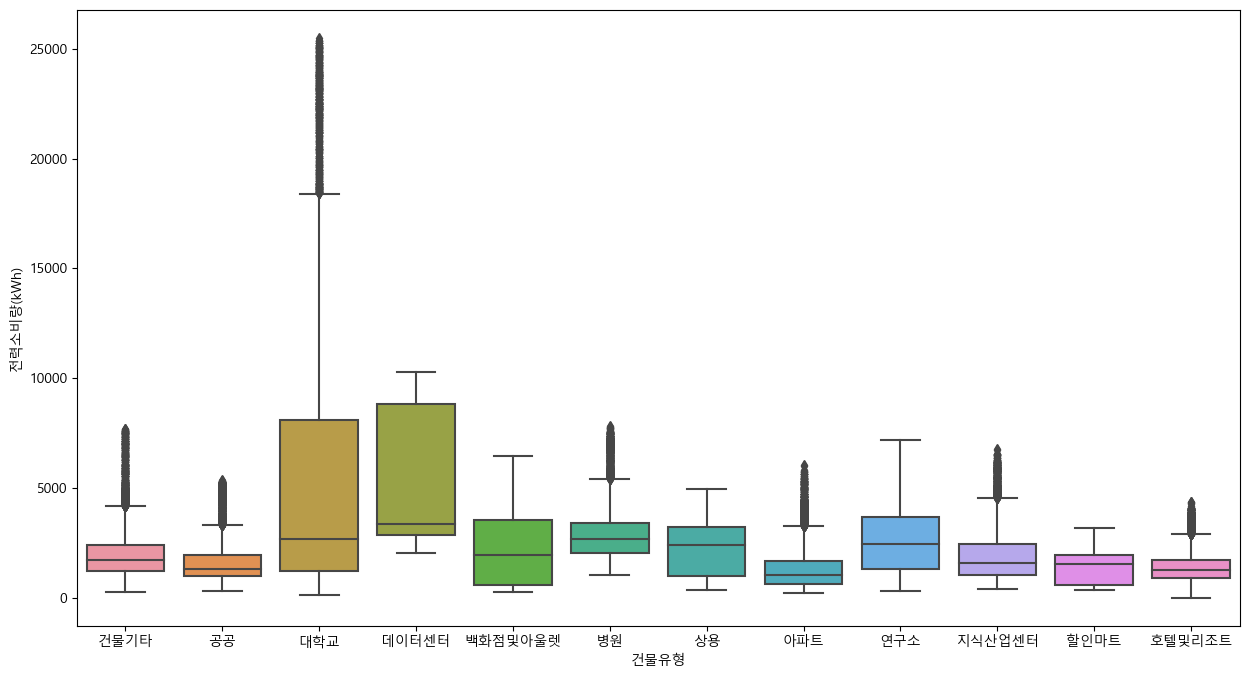

In [54]:
# 건물유형에 따른 전력소비량 그래프로 확인하기
plt.figure(figsize=(15,8))
sns.boxplot(x='건물유형', y='전력소비량(kWh)', data=train_df)
plt.show()

In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   건물번호          204000 non-null  int64         
 1   일시            204000 non-null  datetime64[ns]
 2   기온(C)         204000 non-null  float64       
 3   강수량(mm)       204000 non-null  float64       
 4   풍속(m/s)       204000 non-null  float64       
 5   습도(%)         204000 non-null  float64       
 6   일조(hr)        204000 non-null  float64       
 7   일사(MJ/m2)     204000 non-null  float64       
 8   전력소비량(kWh)    204000 non-null  float64       
 9   YEAR          204000 non-null  int32         
 10  MONTH         204000 non-null  int32         
 11  DAY           204000 non-null  int32         
 12  DATE          204000 non-null  object        
 13  HOUR          204000 non-null  int32         
 14  WEEKDAY       204000 non-null  int32         
 15  DI            204

### 레이블 작업 하기

In [56]:
# 레이블링 작업
le = LabelEncoder()
train_df['DI_CAT'] = le.fit_transform(train_df['DI_CAT'])

### 건물 유형별 corr 확인

In [57]:
#각 건물유형 별 corr 확인하기
building_infos = ['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트']

result_list = []
for index, building_info in enumerate(building_infos):
    result_df = train_df[train_df['건물유형'] == building_info]
    result_df = result_df.drop(['일시', 'DATE', 'HOUR', 'WEEKDAY', '건물유형'], axis=1)
    result_list.append(result_df.corr())


In [58]:
result_list[0]

건물번호     기온(C)   강수량(mm)   풍속(m/s)     습도(%)    일조(hr)  \
건물번호          1.000000e+00 -0.044685 -0.034128  0.070718  0.073842  0.057470   
기온(C)        -4.468540e-02  1.000000 -0.067495  0.164529 -0.388944  0.411565   
강수량(mm)      -3.412773e-02 -0.067495  1.000000  0.035707  0.211258 -0.099540   
풍속(m/s)       7.071759e-02  0.164529  0.035707  1.000000 -0.148925  0.165810   
습도(%)         7.384228e-02 -0.388944  0.211258 -0.148925  1.000000 -0.570216   
일조(hr)        5.746998e-02  0.411565 -0.099540  0.165810 -0.570216  1.000000   
일사(MJ/m2)     1.478834e-02  0.437953 -0.099320  0.258928 -0.538709  0.769990   
전력소비량(kWh)    8.517255e-02  0.236235 -0.022185  0.282337 -0.058778  0.162756   
YEAR                   NaN       NaN       NaN       NaN       NaN       NaN   
MONTH        -1.678595e-15  0.440124  0.043781 -0.089013  0.250887 -0.042697   
DAY          -1.273482e-15  0.061051  0.023415  0.103058  0.128669 -0.080500   
DI           -3.180223e-02  0.954349 -0.011958  0.138733 -0.112090  0.251010   
DI_CAT        1.159866e-02  0.290086 -0.018113  0.021272 -0.119454  0.146094   
연면적(m2)      -3.980688e-01  0.108929  0.001934 -0.114087 -0.119895 -0.022260   
냉방면적(m2)     -2.489342e-01  0.092884 -0.001143 -0.049627 -0.102203 -0.011053   
태양광용량(kW)     2.416289e-01 -0.037126  0.011182 -0.210309  0.040740 -0.021973   
ESS저장용량(kWh) -1.996885e-01  0.020618  0.015948 -0.011800 -0.038657 -0.014636   
PCS용량(kW)    -1.994865e-01  0.020634  0.015769 -0.011274 -0.038424 -0.014949   

              일사(MJ/m2)  전력소비량(kWh)  YEAR         MONTH           DAY  \
건물번호           0.014788    0.085173   NaN -1.678595e-15 -1.273482e-15   
기온(C)          0.437953    0.236235   NaN  4.401239e-01  6.105114e-02   
강수량(mm)       -0.099320   -0.022185   NaN  4.378098e-02  2.341450e-02   
풍속(m/s)        0.258928    0.282337   NaN -8.901267e-02  1.030575e-01   
습도(%)         -0.538709   -0.058778   NaN  2.508874e-01  1.286686e-01   
일조(hr)         0.769990    0.162756   NaN -4.269712e-02 -8.050035e-02   
일사(MJ/m2)      1.000000    0.267865   NaN -2.824903e-02 -5.700345e-02   
전력소비량(kWh)     0.267865    1.000000   NaN  1.023041e-01  2.540153e-02   
YEAR                NaN         NaN   NaN           NaN           NaN   
MONTH         -0.028249    0.102304   NaN  1.000000e+00 -1.333186e-01   
DAY           -0.057003    0.025402   NaN -1.333186e-01  1.000000e+00   
DI             0.289907    0.234367   NaN  5.644117e-01  9.192982e-02   
DI_CAT         0.158537    0.082375   NaN  1.208271e-01  5.252831e-03   
연면적(m2)        0.041703   -0.052800   NaN  8.714730e-15  5.421212e-16   
냉방면적(m2)       0.050035   -0.041983   NaN  5.987568e-15  1.262420e-15   
태양광용량(kW)     -0.156317   -0.095947   NaN -4.067124e-15 -8.241426e-16   
ESS저장용량(kWh)   0.015439    0.096755   NaN  1.090872e-14  9.122955e-16   
PCS용량(kW)      0.015233    0.100848   NaN  1.126334e-14  1.022605e-15   

                    DI    DI_CAT       연면적(m2)      냉방면적(m2)     태양광용량(kW)  \
건물번호         -0.031802  0.011599 -3.980688e-01 -2.489342e-01  2.416289e-01   
기온(C)         0.954349  0.290086  1.089286e-01  9.288398e-02 -3.712625e-02   
강수량(mm)      -0.011958 -0.018113  1.933512e-03 -1.142700e-03  1.118214e-02   
풍속(m/s)       0.138733  0.021272 -1.140874e-01 -4.962691e-02 -2.103089e-01   
습도(%)        -0.112090 -0.119454 -1.198948e-01 -1.022028e-01  4.073954e-02   
일조(hr)        0.251010  0.146094 -2.226028e-02 -1.105285e-02 -2.197288e-02   
일사(MJ/m2)     0.289907  0.158537  4.170282e-02  5.003451e-02 -1.563174e-01   
전력소비량(kWh)    0.234367  0.082375 -5.280004e-02 -4.198280e-02 -9.594718e-02   
YEAR               NaN       NaN           NaN           NaN           NaN   
MONTH         0.564412  0.120827  8.714730e-15  5.987568e-15 -4.067124e-15   
DAY           0.091930  0.005253  5.421212e-16  1.262420e-15 -8.241426e-16   
DI            1.000000  0.263017  7.829273e-02  6.509149e-02 -3.149265e-02   
DI_CAT        0.263017  1.000000  4.077786e-02  8.890597e-03  4.231873e-03   
연면적(m2)       0.07829

In [59]:
result_list[0].iloc[:, 7]

건물번호            0.085173
기온(C)           0.236235
강수량(mm)        -0.022185
풍속(m/s)         0.282337
습도(%)          -0.058778
일조(hr)          0.162756
일사(MJ/m2)       0.267865
전력소비량(kWh)      1.000000
YEAR                 NaN
MONTH           0.102304
DAY             0.025402
DI              0.234367
DI_CAT          0.082375
연면적(m2)        -0.052800
냉방면적(m2)       -0.041983
태양광용량(kW)      -0.095947
ESS저장용량(kWh)    0.096755
PCS용량(kW)       0.100848
Name: 전력소비량(kWh), dtype: float64

In [60]:
# corr 리스트로 담기
corr_list = []
for index, building_info in enumerate(building_infos):
    corr_list.append(result_list[index].iloc[:, 7])

In [61]:
corr_list[0]

건물번호            0.085173
기온(C)           0.236235
강수량(mm)        -0.022185
풍속(m/s)         0.282337
습도(%)          -0.058778
일조(hr)          0.162756
일사(MJ/m2)       0.267865
전력소비량(kWh)      1.000000
YEAR                 NaN
MONTH           0.102304
DAY             0.025402
DI              0.234367
DI_CAT          0.082375
연면적(m2)        -0.052800
냉방면적(m2)       -0.041983
태양광용량(kW)      -0.095947
ESS저장용량(kWh)    0.096755
PCS용량(kW)       0.100848
Name: 전력소비량(kWh), dtype: float64

In [62]:
# DF 만들기
corr_df = pd.DataFrame(corr_list)

In [63]:
corr_df

건물번호     기온(C)   강수량(mm)   풍속(m/s)     습도(%)    일조(hr)  \
전력소비량(kWh)  0.085173  0.236235 -0.022185  0.282337 -0.058778  0.162756   
전력소비량(kWh) -0.305826  0.250507 -0.001584  0.078046 -0.121128  0.244346   
전력소비량(kWh) -0.542149  0.200199  0.035565  0.183219 -0.163403  0.037689   
전력소비량(kWh) -0.899177  0.045193 -0.008693  0.044887  0.000324 -0.022131   
전력소비량(kWh) -0.139707  0.526836  0.029966  0.334299 -0.439241  0.436299   
전력소비량(kWh) -0.221211  0.228532  0.061036  0.104671 -0.143888  0.202967   
전력소비량(kWh)  0.197969  0.223891  0.041128  0.075400 -0.248643  0.212702   
전력소비량(kWh) -0.247537  0.238030  0.051554  0.157841 -0.087768  0.006074   
전력소비량(kWh) -0.492828  0.168468  0.072895  0.266985 -0.183352  0.081990   
전력소비량(kWh) -0.054054  0.369746  0.008839  0.268062 -0.208197  0.335092   
전력소비량(kWh) -0.199769  0.490634  0.014782  0.277690 -0.369256  0.381672   
전력소비량(kWh) -0.332346  0.318620  0.011535  0.393115 -0.140757  0.212940   

            일사(MJ/m2)  전력소비량(kWh)  YEAR     MONTH       DAY        DI  \
전력소비량(kWh)   0.267865         1.0   NaN  0.102304  0.025402  0.234367   
전력소비량(kWh)   0.297578         1.0   NaN  0.104267  0.023530  0.233102   
전력소비량(kWh)   0.242598         1.0   NaN  0.049060  0.006769  0.168492   
전력소비량(kWh)   0.001634         1.0   NaN  0.022013  0.005233  0.050753   
전력소비량(kWh)   0.601612         1.0   NaN  0.073232  0.006869  0.435559   
전력소비량(kWh)   0.266376         1.0   NaN  0.149368  0.032439  0.200134   
전력소비량(kWh)   0.294823         1.0   NaN  0.078418  0.020810  0.151267   
전력소비량(kWh)   0.009963         1.0   NaN  0.163134 -0.010399  0.231778   
전력소비량(kWh)   0.229473         1.0   NaN  0.089790  0.028544  0.119814   
전력소비량(kWh)   0.494492         1.0   NaN  0.120975  0.027796  0.321204   
전력소비량(kWh)   0.526224         1.0   NaN  0.116283  0.002758  0.409874   
전력소비량(kWh)   0.441318         1.0   NaN  0.166739  0.011758  0.317966   

              DI_CAT   연면적(m2)  냉방면적(m2)  태양광용량(kW)  ESS저장용량(kWh)  PCS용량(kW)  
전력소비량(kWh)  0.082375 -0.052800 -0.041983  -0.095947      0.096755   0.100848  
전력소비량(kWh)  0.071059  0.022561  0.017164  -0.025099     -0.023879   0.012287  
전력소비량(kWh)  0.038931  0.810922  0.872589   0.099215           NaN        NaN  
전력소비량(kWh) -0.004456  0.988651  0.879894        NaN           NaN        NaN  
전력소비량(kWh)  0.175663  0.161694  0.153810   0.247372           NaN        NaN  
전력소비량(kWh)  0.095103  0.805026  0.788468  -0.443685           NaN        NaN  
전력소비량(kWh)  0.044536 -0.049436 -0.101601   0.124870           NaN        NaN  
전력소비량(kWh)  0.052541  0.800428  0.642104        NaN           NaN        NaN  
전력소비량(kWh)  0.032403  0.640413  0.764188   0.210097     -0.154890  -0.154890  
전력소비량(kWh)  0.116438  0.334479  0.036095        NaN           NaN        NaN  
전력소비량(kWh)  0.165964  0.153107  0.044204  -0.155501           NaN        NaN  
전력소비량(kWh)  0.094367  0.039584  0.527423  -0.173106           NaN        NaN

In [64]:
corr_df.index = ['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트']

In [65]:
corr_df

건물번호     기온(C)   강수량(mm)   풍속(m/s)     습도(%)    일조(hr)  \
건물기타     0.085173  0.236235 -0.022185  0.282337 -0.058778  0.162756   
공공      -0.305826  0.250507 -0.001584  0.078046 -0.121128  0.244346   
대학교     -0.542149  0.200199  0.035565  0.183219 -0.163403  0.037689   
데이터센터   -0.899177  0.045193 -0.008693  0.044887  0.000324 -0.022131   
백화점및아울렛 -0.139707  0.526836  0.029966  0.334299 -0.439241  0.436299   
병원      -0.221211  0.228532  0.061036  0.104671 -0.143888  0.202967   
상용       0.197969  0.223891  0.041128  0.075400 -0.248643  0.212702   
아파트     -0.247537  0.238030  0.051554  0.157841 -0.087768  0.006074   
연구소     -0.492828  0.168468  0.072895  0.266985 -0.183352  0.081990   
지식산업센터  -0.054054  0.369746  0.008839  0.268062 -0.208197  0.335092   
할인마트    -0.199769  0.490634  0.014782  0.277690 -0.369256  0.381672   
호텔및리조트  -0.332346  0.318620  0.011535  0.393115 -0.140757  0.212940   

         일사(MJ/m2)  전력소비량(kWh)  YEAR     MONTH       DAY        DI    DI_CAT  \
건물기타      0.267865         1.0   NaN  0.102304  0.025402  0.234367  0.082375   
공공        0.297578         1.0   NaN  0.104267  0.023530  0.233102  0.071059   
대학교       0.242598         1.0   NaN  0.049060  0.006769  0.168492  0.038931   
데이터센터     0.001634         1.0   NaN  0.022013  0.005233  0.050753 -0.004456   
백화점및아울렛   0.601612         1.0   NaN  0.073232  0.006869  0.435559  0.175663   
병원        0.266376         1.0   NaN  0.149368  0.032439  0.200134  0.095103   
상용        0.294823         1.0   NaN  0.078418  0.020810  0.151267  0.044536   
아파트       0.009963         1.0   NaN  0.163134 -0.010399  0.231778  0.052541   
연구소       0.229473         1.0   NaN  0.089790  0.028544  0.119814  0.032403   
지식산업센터    0.494492         1.0   NaN  0.120975  0.027796  0.321204  0.116438   
할인마트      0.526224         1.0   NaN  0.116283  0.002758  0.409874  0.165964   
호텔및리조트    0.441318         1.0   NaN  0.166739  0.011758  0.317966  0.094367   

          연면적(m2)  냉방면적(m2)  태양광용량(kW)  ESS저장용량(kWh)  PCS용량(kW)  
건물기타    -0.052800 -0.041983  -0.095947      0.096755   0.100848  
공공       0.022561  0.017164  -0.025099     -0.023879   0.012287  
대학교      0.810922  0.872589   0.099215           NaN        NaN  
데이터센터    0.988651  0.879894        NaN           NaN        NaN  
백화점및아울렛  0.161694  0.153810   0.247372           NaN        NaN  
병원       0.805026  0.788468  -0.443685           NaN        NaN  
상용      -0.049436 -0.101601   0.124870           NaN        NaN  
아파트      0.800428  0.642104        NaN           NaN        NaN  
연구소      0.640413  0.764188   0.210097     -0.154890  -0.154890  
지식산업센터   0.334479  0.036095        NaN           NaN        NaN  
할인마트     0.153107  0.044204  -0.155501           NaN        NaN  
호텔및리조트   0.039584  0.527423  -0.173106           NaN        NaN

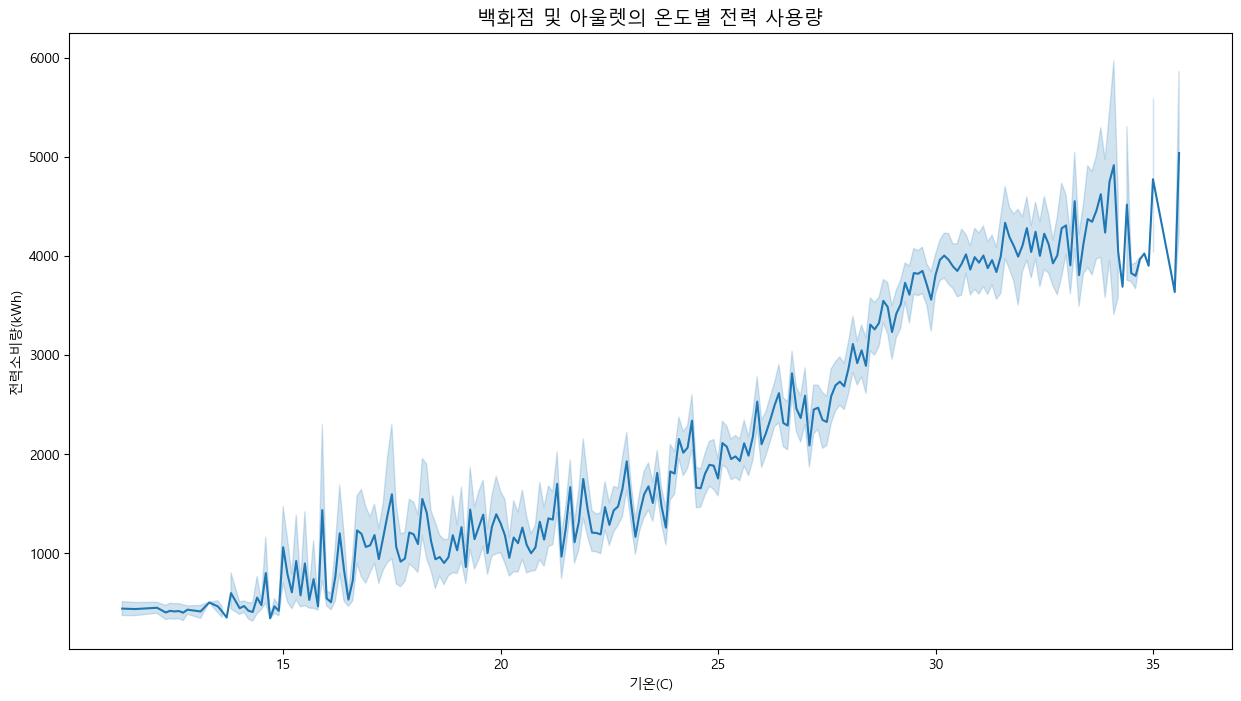

In [66]:
# 백화점 및 아울렛의 온도별 전력 사용량 그래프

dept_outlet_df = train_df[train_df['건물유형'] == '백화점및아울렛']

plt.figure(figsize=(15,8))
plt.title('백화점 및 아울렛의 온도별 전력 사용량', fontsize=14)
sns.lineplot(x='기온(C)', y='전력소비량(kWh)', data=dept_outlet_df)
plt.show()

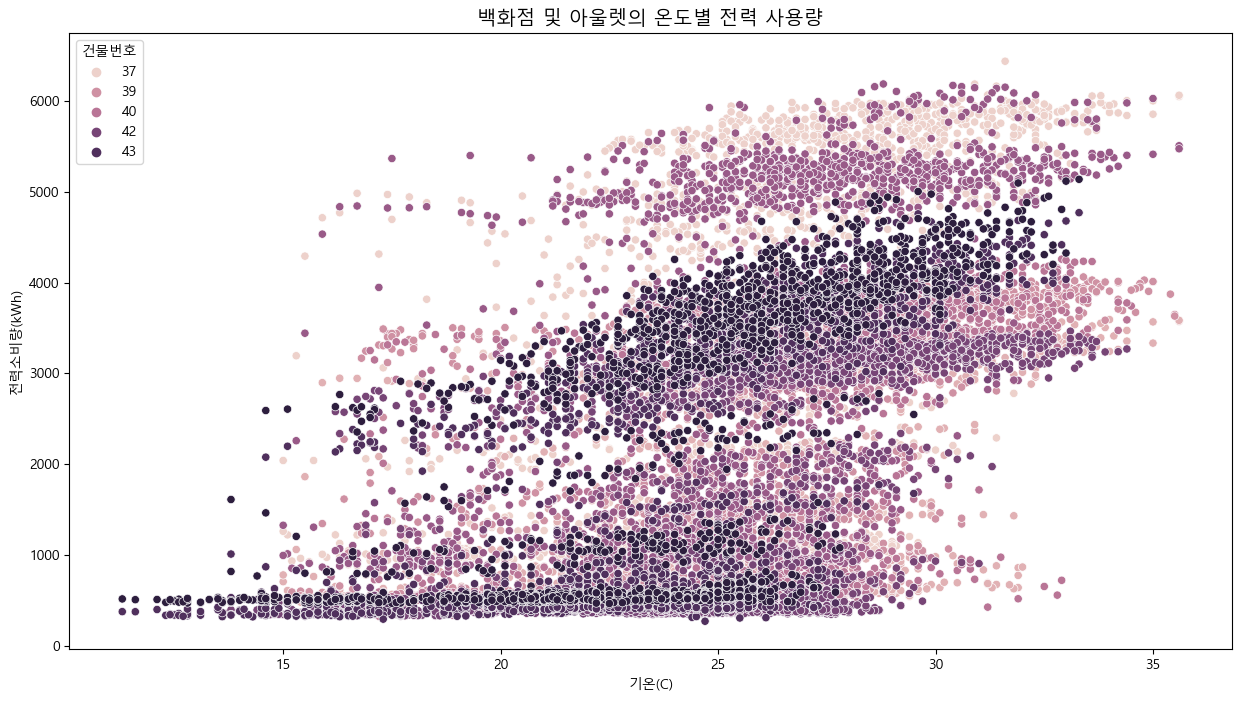

In [67]:
# 백화점 및 아울렛의 온도별 전력 사용량 그래프

dept_outlet_df = train_df[train_df['건물유형'] == '백화점및아울렛']

plt.figure(figsize=(15,8))
plt.title('백화점 및 아울렛의 온도별 전력 사용량', fontsize=14)
sns.scatterplot(x='기온(C)', y='전력소비량(kWh)', hue='건물번호', data=dept_outlet_df)
plt.show()

### 분석결과 : '백화점 및 아울렛' 유형과 '할인마트' 유형이 온도가 올라갈 수록 전기사용량이 뚜렷하게 증가함

## 레이블 작업 하기

In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   건물번호          204000 non-null  int64         
 1   일시            204000 non-null  datetime64[ns]
 2   기온(C)         204000 non-null  float64       
 3   강수량(mm)       204000 non-null  float64       
 4   풍속(m/s)       204000 non-null  float64       
 5   습도(%)         204000 non-null  float64       
 6   일조(hr)        204000 non-null  float64       
 7   일사(MJ/m2)     204000 non-null  float64       
 8   전력소비량(kWh)    204000 non-null  float64       
 9   YEAR          204000 non-null  int32         
 10  MONTH         204000 non-null  int32         
 11  DAY           204000 non-null  int32         
 12  DATE          204000 non-null  object        
 13  HOUR          204000 non-null  int32         
 14  WEEKDAY       204000 non-null  int32         
 15  DI            204

In [69]:
# 레이블링 작업
le = LabelEncoder()
train_df['건물유형'] = le.fit_transform(train_df['건물유형'])

In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   건물번호          204000 non-null  int64         
 1   일시            204000 non-null  datetime64[ns]
 2   기온(C)         204000 non-null  float64       
 3   강수량(mm)       204000 non-null  float64       
 4   풍속(m/s)       204000 non-null  float64       
 5   습도(%)         204000 non-null  float64       
 6   일조(hr)        204000 non-null  float64       
 7   일사(MJ/m2)     204000 non-null  float64       
 8   전력소비량(kWh)    204000 non-null  float64       
 9   YEAR          204000 non-null  int32         
 10  MONTH         204000 non-null  int32         
 11  DAY           204000 non-null  int32         
 12  DATE          204000 non-null  object        
 13  HOUR          204000 non-null  int32         
 14  WEEKDAY       204000 non-null  int32         
 15  DI            204

In [71]:
# 컬럼 삭제
train_df.drop(['일시', 'DATE'], axis=1, inplace=True)

## 모델 선정하기

### cross val score 로 적합한 모델을 확인해 보기

In [72]:
x_train = train_df.drop(['전력소비량(kWh)'], axis=1)
y_train = train_df['전력소비량(kWh)']

In [73]:
# 성능 지표, 교차 검증 세트
# neg_mean_absolute_error, neg_mean_squared_error, neg_root_mean_squared_error
score_param = 'neg_root_mean_squared_error'
cv_param = 5
round_param = 4

model = LinearRegression(n_jobs=-1)

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-28925.7667  -4832.2838  -1260.1199  -1595.839    -988.3272]
평균 검증 정확도: -7520.4673


In [74]:
model = SGDRegressor()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-3.92667923e+19 -5.95124897e+20 -3.49462690e+20 -5.44100967e+20
 -4.89663305e+18]
평균 검증 정확도: -3.0657039576537576e+20


In [75]:
model = ARDRegression()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-28987.6618  -4832.7102  -1255.2374  -1559.367    -944.6062]
평균 검증 정확도: -7515.9165


In [77]:
model = RandomForestRegressor(n_jobs=-1)

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1595.9338 -4392.0235 -1682.077  -3981.8772 -2219.7297]
평균 검증 정확도: -2774.3282


In [78]:
model = GradientBoostingRegressor()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1815.2427 -4564.8187 -1465.8506 -3583.5325 -1083.1438]
평균 검증 정확도: -2502.5177


In [80]:
model = BaggingRegressor()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1672.3379 -4380.5166 -1642.9136 -3950.2271 -2241.4605]
평균 검증 정확도: -2777.4912


In [79]:
model = XGBRegressor(random_state=42)

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1992.4462 -4539.5899 -1498.7925 -3776.6816 -1227.8024]
평균 검증 정확도: -2607.0625


In [81]:
model = LGBMRegressor(random_state=42)

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1937.4342 -4590.8498 -1506.2636 -3762.9069 -1112.5726]
평균 검증 정확도: -2582.0054


In [83]:
model = CatBoostRegressor(random_state=42)

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

Learning rate set to 0.091578
0:	learn: 2478.4820405	total: 160ms	remaining: 2m 40s
1:	learn: 2319.0063645	total: 169ms	remaining: 1m 24s
2:	learn: 2176.2253522	total: 175ms	remaining: 58s
3:	learn: 2049.1773778	total: 179ms	remaining: 44.6s
4:	learn: 1921.8013304	total: 187ms	remaining: 37.2s
5:	learn: 1808.3409445	total: 194ms	remaining: 32.1s
6:	learn: 1720.0335465	total: 202ms	remaining: 28.7s
7:	learn: 1639.1096154	total: 209ms	remaining: 26s
8:	learn: 1562.0114376	total: 215ms	remaining: 23.7s
9:	learn: 1496.6189458	total: 221ms	remaining: 21.9s
10:	learn: 1427.1609917	total: 226ms	remaining: 20.3s
11:	learn: 1365.5065308	total: 231ms	remaining: 19.1s
12:	learn: 1310.3339557	total: 238ms	remaining: 18.1s
13:	learn: 1264.3081865	total: 244ms	remaining: 17.2s
14:	learn: 1218.8245922	total: 249ms	remaining: 16.4s
15:	learn: 1183.6430752	total: 254ms	remaining: 15.6s
16:	learn: 1150.8424731	total: 259ms	remaining: 15s
17:	learn: 1111.7102891	total: 264ms	remaining: 14.4s
18:	learn: 1

### Cross val score 검증 결과 : 아래의 모델이 성능이 좋게 나옴
- RandomForestRegressor
- GradientBoostingRegressor
- BaggingRegressor
- XGBRegressor
- LGBMRegressor
- CatBoostRegressor

### train test 분리

In [84]:
x_train, x_test, y_train, y_test = train_test_split(train_df.drop(['전력소비량(kWh)'], axis=1), train_df['전력소비량(kWh)'], test_size=0.2, random_state=123)

### 모델별 성능 확인을 위한 함수

In [85]:
my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

### LinearRegression

In [86]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(x_train, y_train)
pred = linear_reg.predict(x_test)
print(linear_reg.coef_)
print(linear_reg.intercept_)

[-5.47323796e+01  6.90173150e+01  2.86159139e+01  8.68226217e+01
 -7.62566481e+00 -7.63196545e+02  5.06069166e+02 -1.70530257e-12
  1.48298158e+02  4.22297563e+00  1.56933815e+01 -4.93035557e+01
 -1.66982167e+01 -3.11959893e+01  3.07799135e+02 -2.40252501e-03
  2.84524243e-03  1.45664898e+00  7.46224349e-01 -3.46756363e+00]
2390.6583274316663


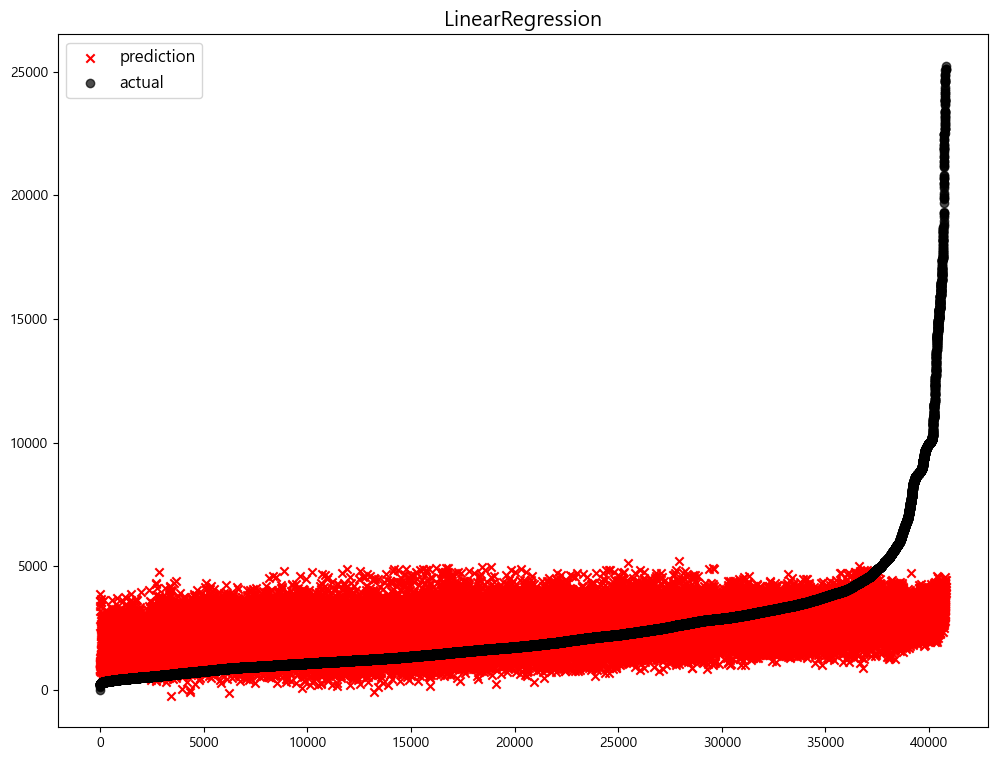

              model           mse
0  LinearRegression  5.297717e+06


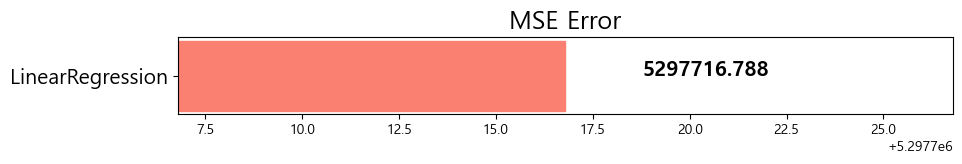

In [87]:
mse_eval('LinearRegression', pred, y_test)

#### Ridge

In [89]:
# 값이 커질 수록 큰 규제입니다.
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

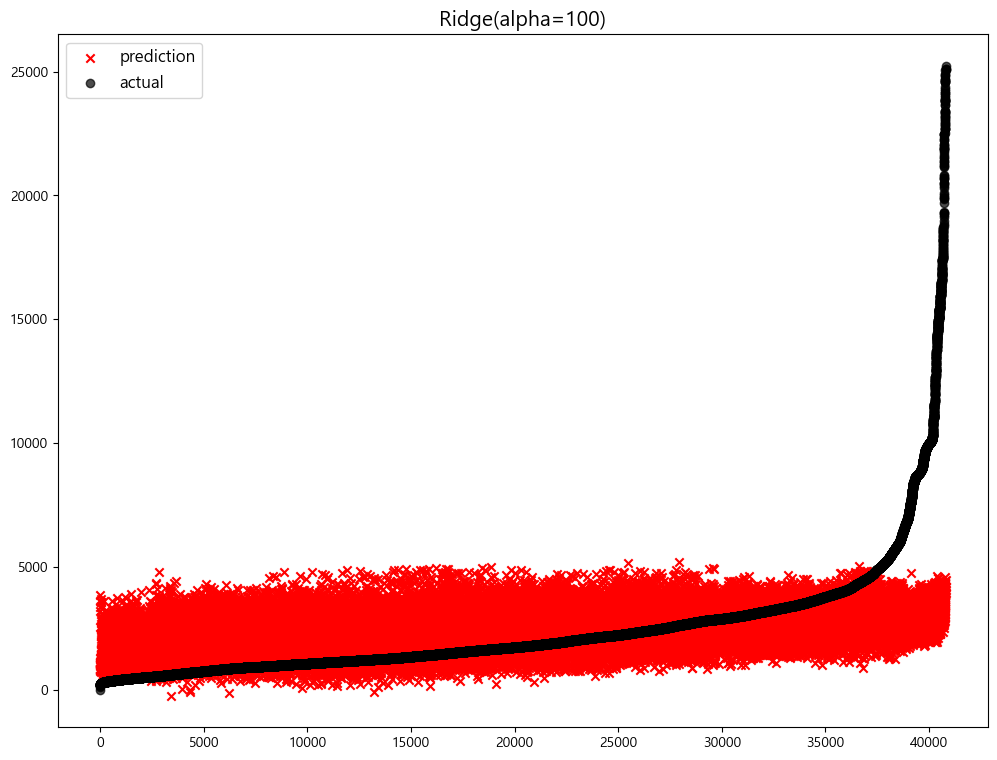

              model           mse
0  LinearRegression  5.297717e+06
1  Ridge(alpha=100)  5.297711e+06


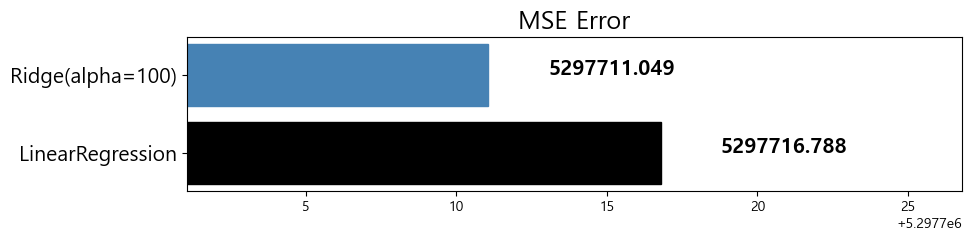

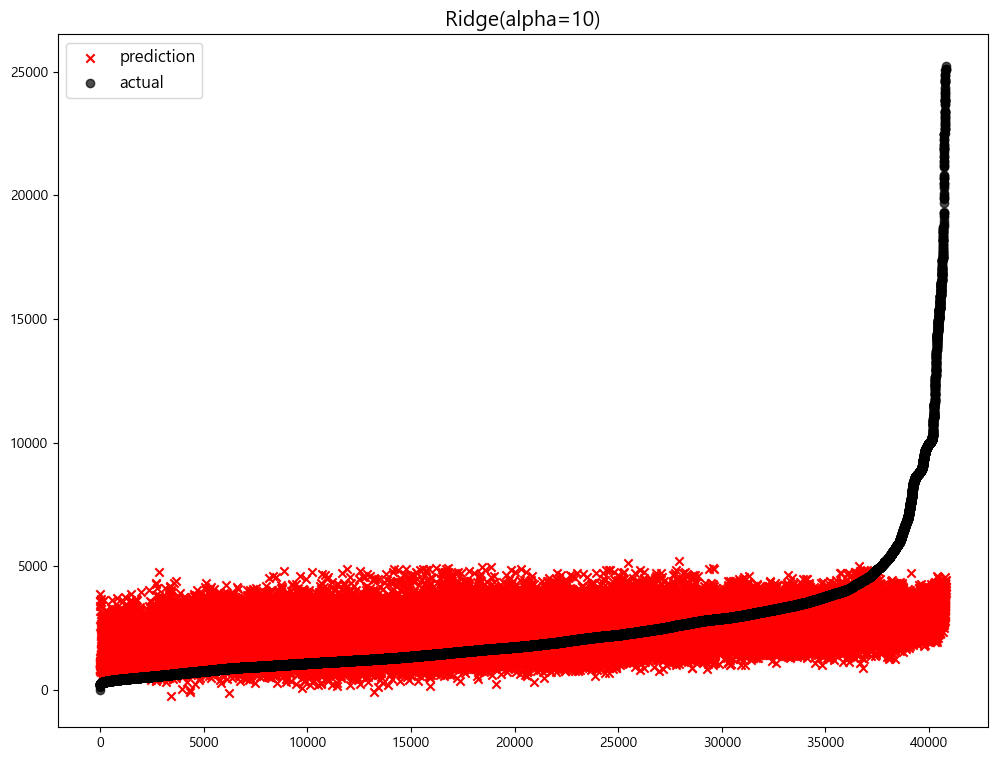

              model           mse
0  LinearRegression  5.297717e+06
1   Ridge(alpha=10)  5.297716e+06
2  Ridge(alpha=100)  5.297711e+06


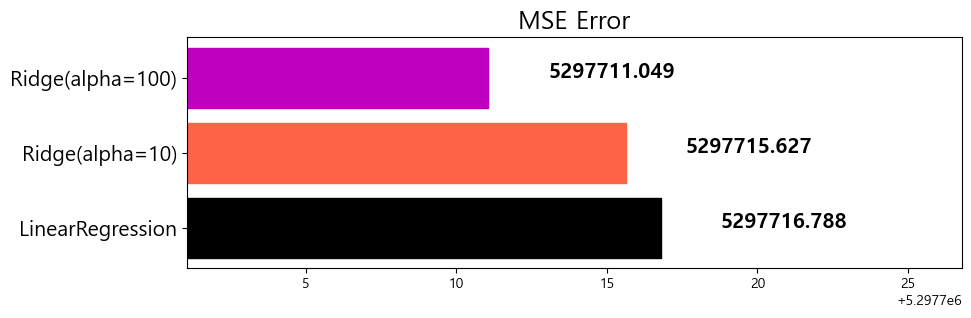

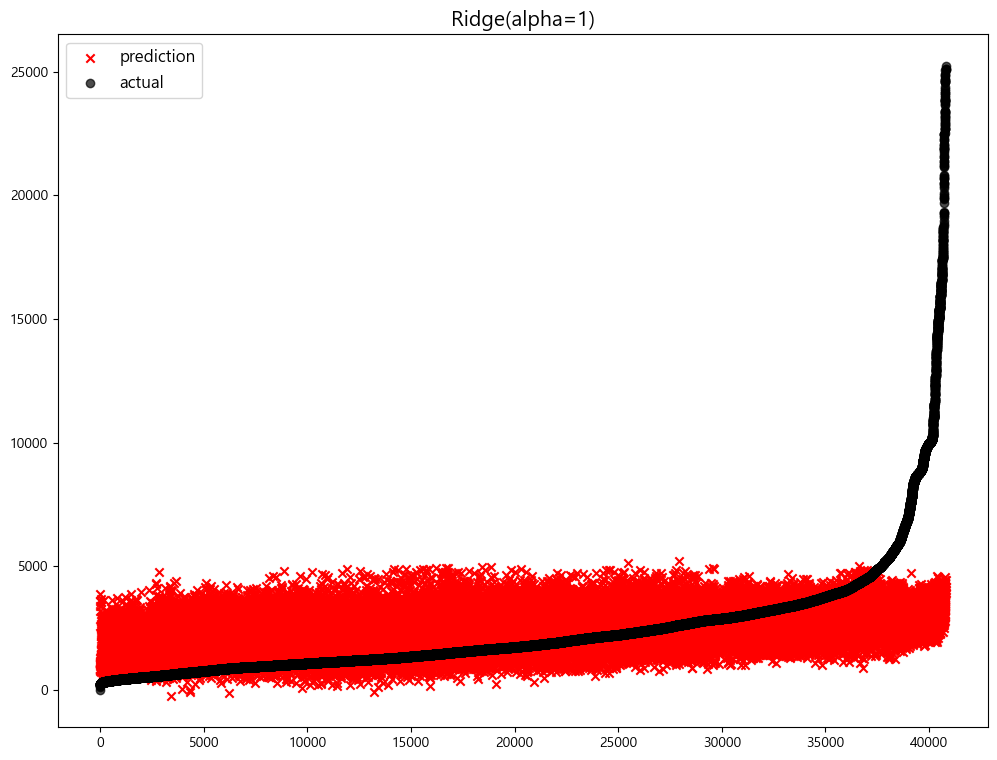

              model           mse
0  LinearRegression  5.297717e+06
1    Ridge(alpha=1)  5.297717e+06
2   Ridge(alpha=10)  5.297716e+06
3  Ridge(alpha=100)  5.297711e+06


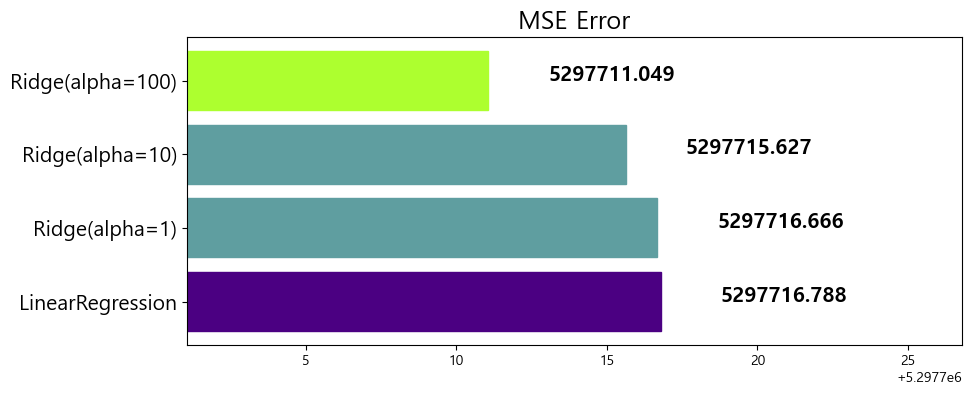

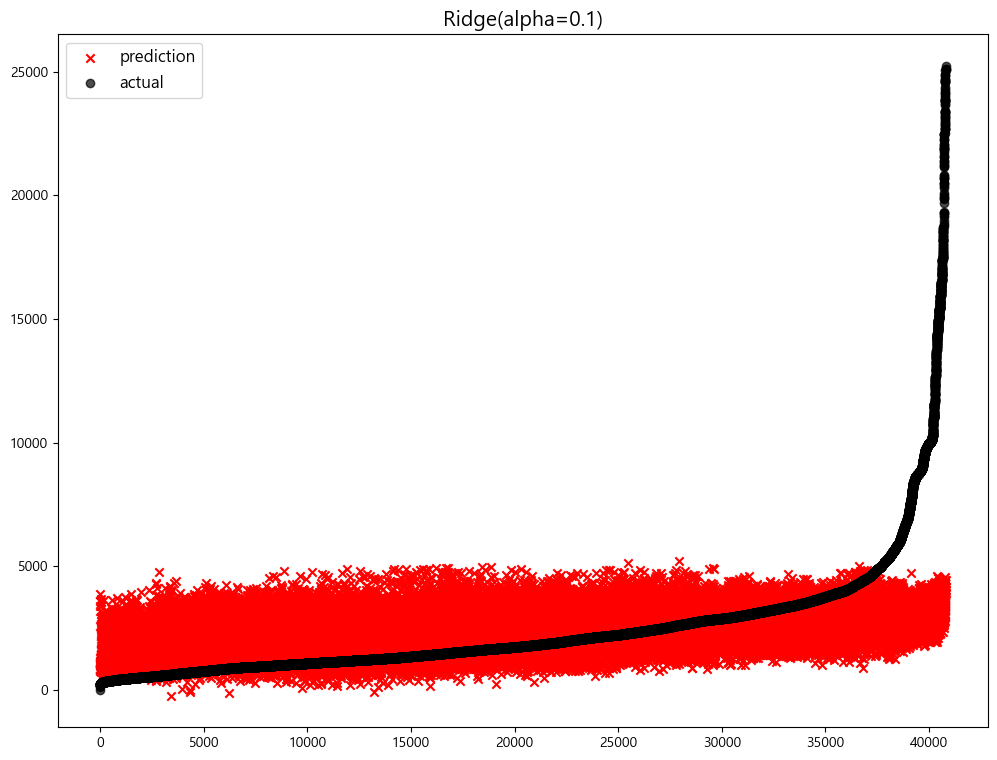

              model           mse
0  LinearRegression  5.297717e+06
1  Ridge(alpha=0.1)  5.297717e+06
2    Ridge(alpha=1)  5.297717e+06
3   Ridge(alpha=10)  5.297716e+06
4  Ridge(alpha=100)  5.297711e+06


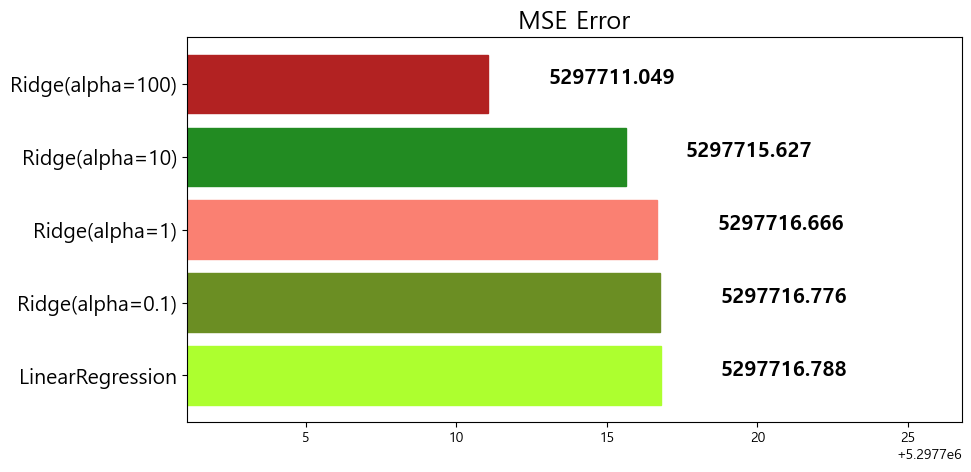

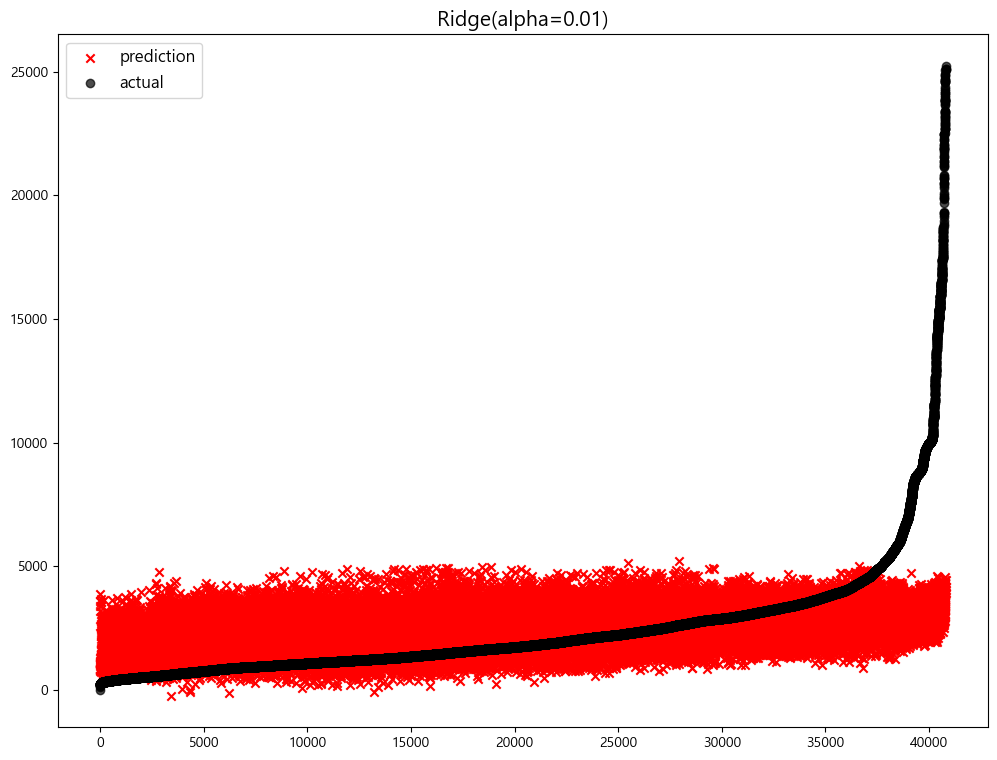

               model           mse
0   LinearRegression  5.297717e+06
1  Ridge(alpha=0.01)  5.297717e+06
2   Ridge(alpha=0.1)  5.297717e+06
3     Ridge(alpha=1)  5.297717e+06
4    Ridge(alpha=10)  5.297716e+06
5   Ridge(alpha=100)  5.297711e+06


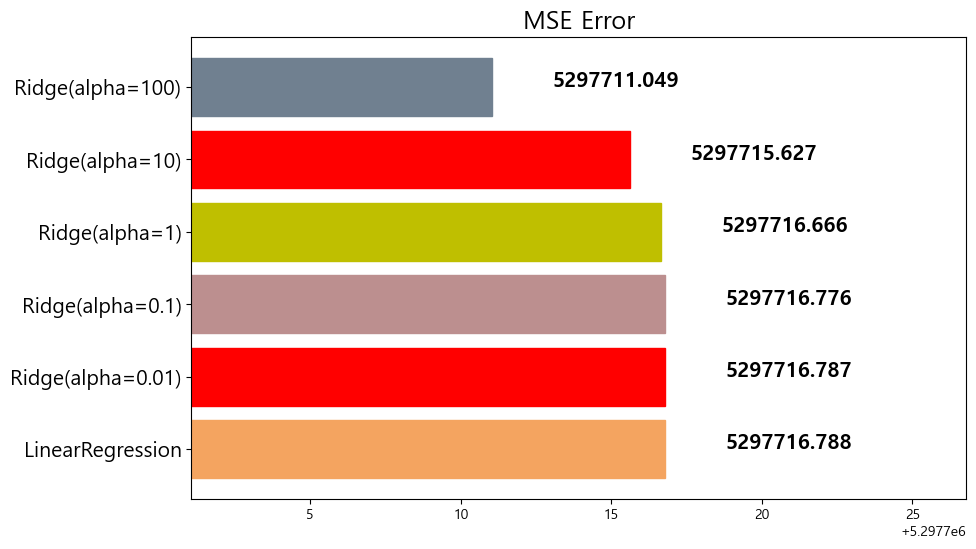

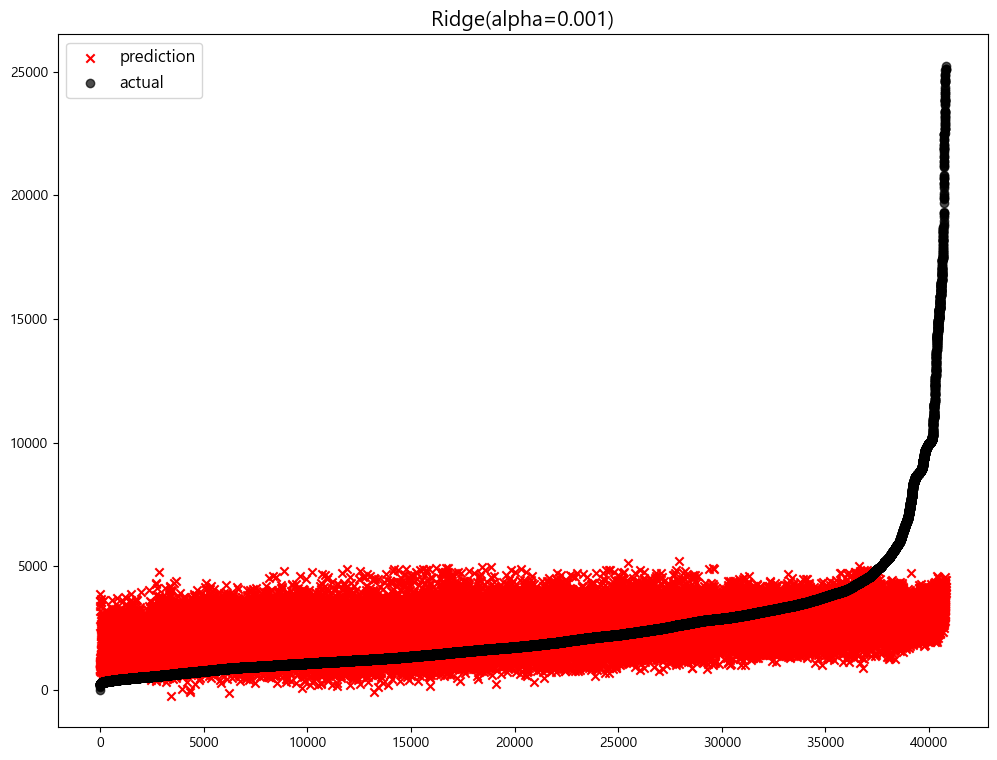

                model           mse
0    LinearRegression  5.297717e+06
1  Ridge(alpha=0.001)  5.297717e+06
2   Ridge(alpha=0.01)  5.297717e+06
3    Ridge(alpha=0.1)  5.297717e+06
4      Ridge(alpha=1)  5.297717e+06
5     Ridge(alpha=10)  5.297716e+06
6    Ridge(alpha=100)  5.297711e+06


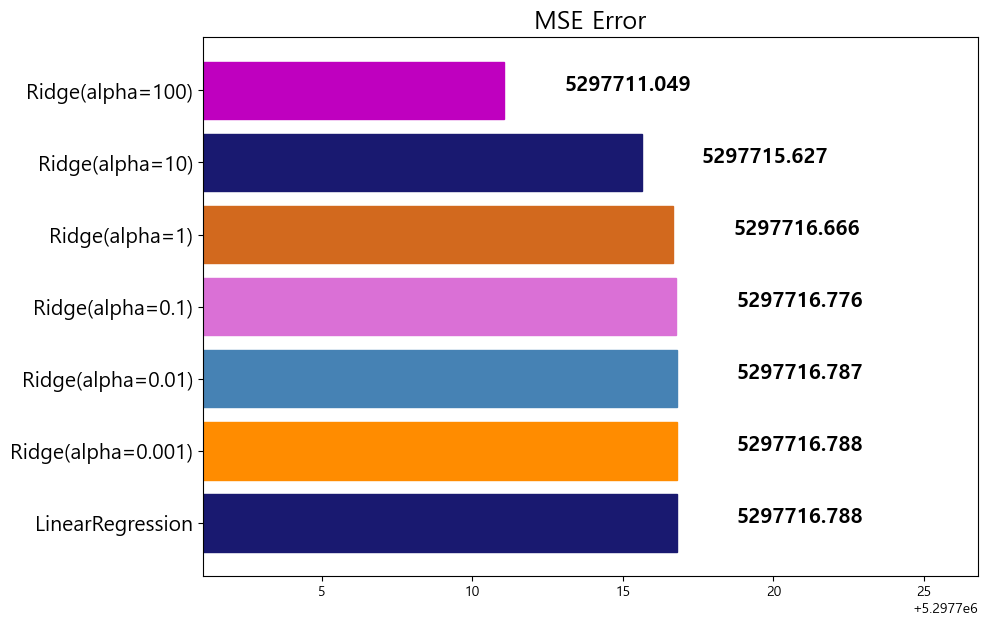

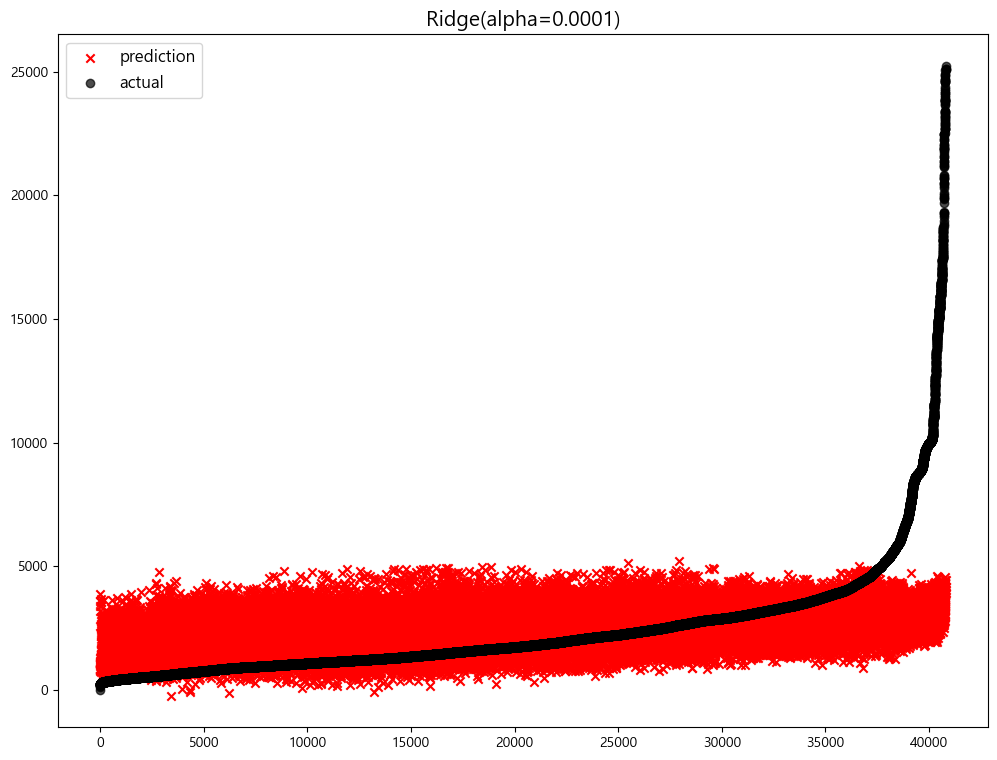

                 model           mse
0     LinearRegression  5.297717e+06
1  Ridge(alpha=0.0001)  5.297717e+06
2   Ridge(alpha=0.001)  5.297717e+06
3    Ridge(alpha=0.01)  5.297717e+06
4     Ridge(alpha=0.1)  5.297717e+06
5       Ridge(alpha=1)  5.297717e+06
6      Ridge(alpha=10)  5.297716e+06
7     Ridge(alpha=100)  5.297711e+06


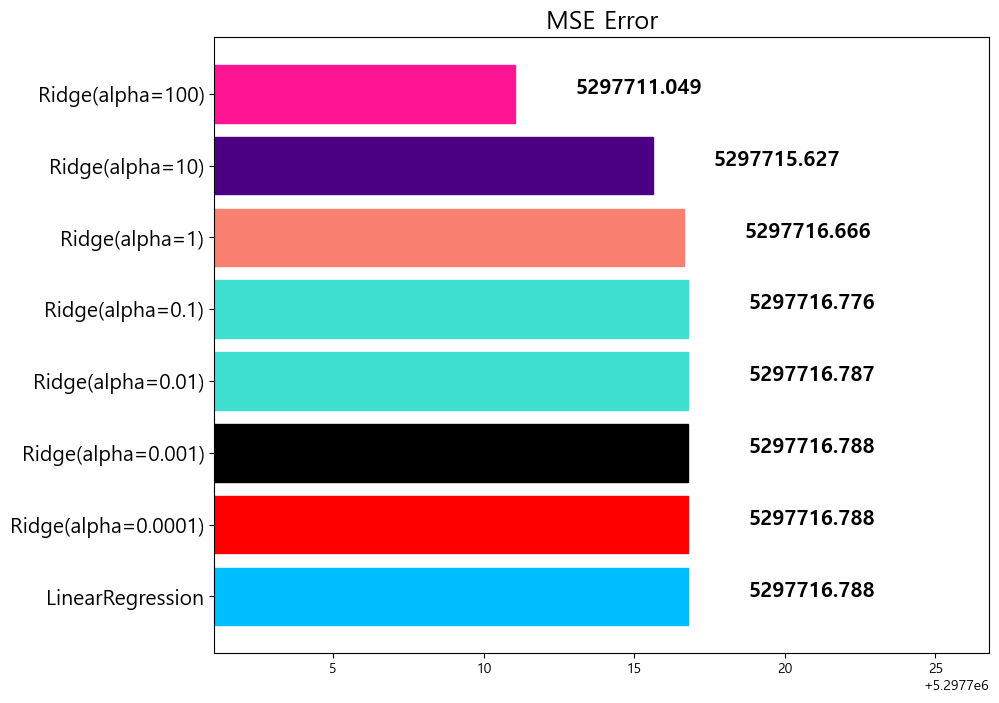

In [90]:
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train, y_train)
    pred = ridge.predict(x_test)
    mse_eval('Ridge(alpha={})'.format(alpha), pred, y_test)

In [91]:
ridge.coef_

array([-5.47323795e+01,  6.90173141e+01,  2.86159139e+01,  8.68226218e+01,
       -7.62566483e+00, -7.63196533e+02,  5.06069163e+02,  0.00000000e+00,
        1.48298158e+02,  4.22297563e+00,  1.56933815e+01, -4.93035557e+01,
       -1.66982161e+01, -3.11959893e+01,  3.07799134e+02, -2.40252501e-03,
        2.84524243e-03,  1.45664898e+00,  7.46224350e-01, -3.46756363e+00])

#### ridge 값을 100으로 설정함

In [92]:
# ridge 의 alpha 값 100을 적용
ridge = Ridge(alpha=100)
ridge_pred = ridge.fit(x_train,y_train).predict(x_test)

#### Lasso

In [93]:
# 값이 커질 수록 큰 규제입니다.
# alpha값이 커질수록 직선에 가까워진다.
alphas = [1, 0.1, 0.01, 0.001, 0.0001]

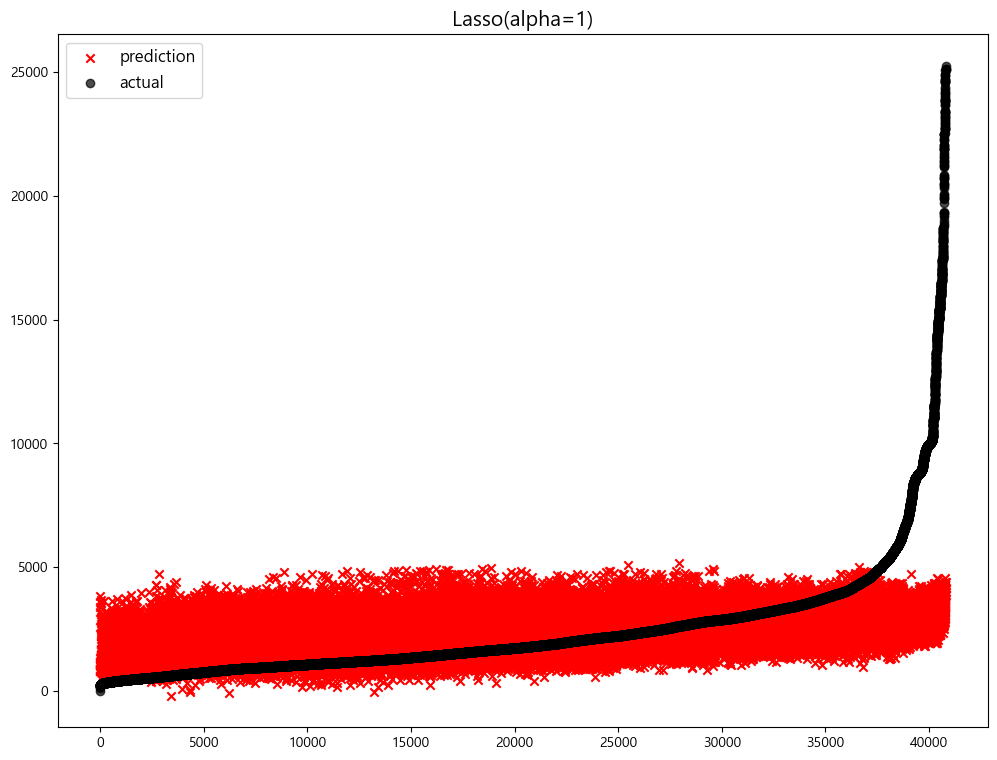

                 model           mse
0     LinearRegression  5.297717e+06
1  Ridge(alpha=0.0001)  5.297717e+06
2   Ridge(alpha=0.001)  5.297717e+06
3    Ridge(alpha=0.01)  5.297717e+06
4     Ridge(alpha=0.1)  5.297717e+06
5       Ridge(alpha=1)  5.297717e+06
6      Ridge(alpha=10)  5.297716e+06
7     Ridge(alpha=100)  5.297711e+06
8       Lasso(alpha=1)  5.297629e+06


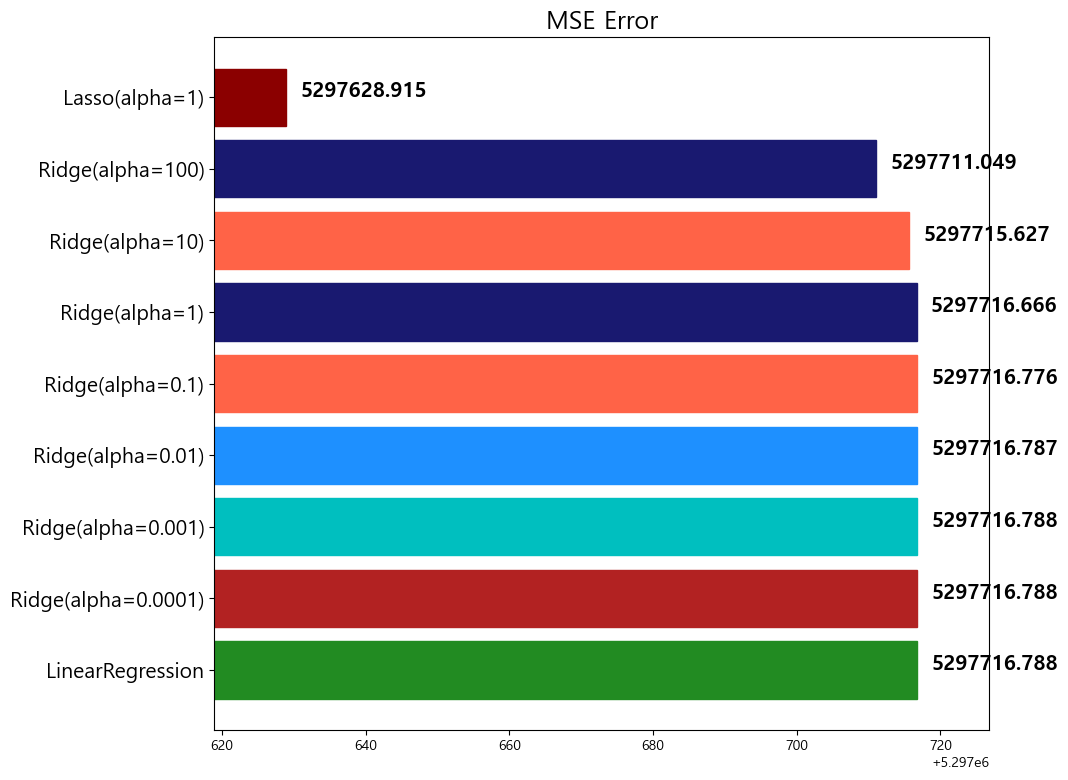

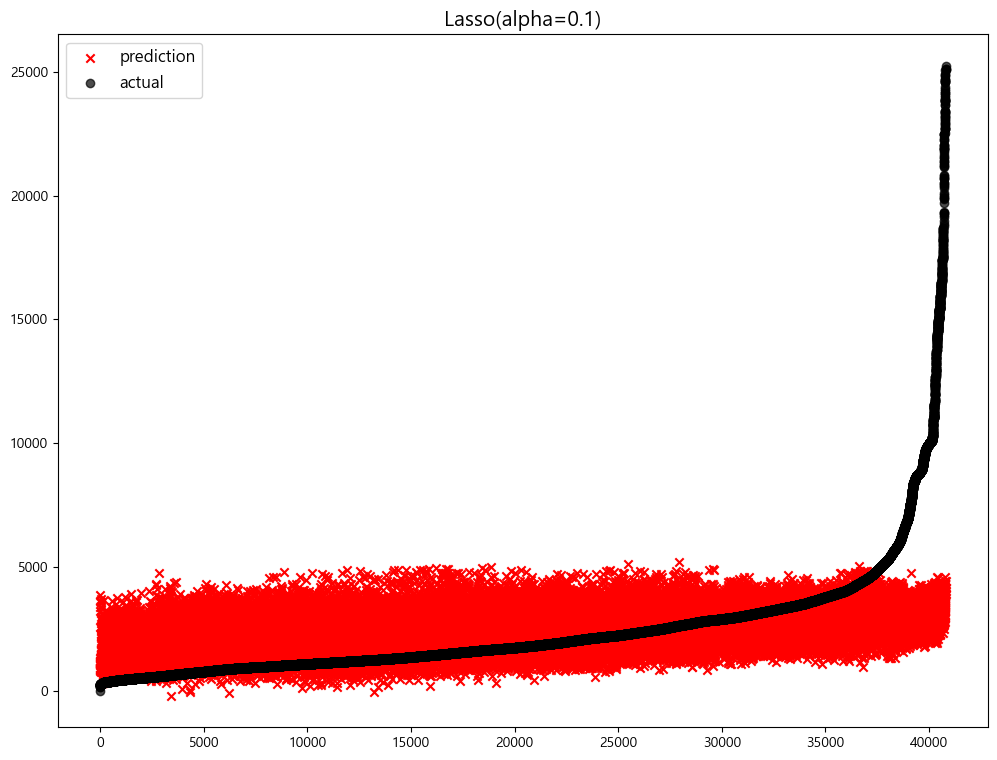

                 model           mse
0     Lasso(alpha=0.1)  5.297785e+06
1     LinearRegression  5.297717e+06
2  Ridge(alpha=0.0001)  5.297717e+06
3   Ridge(alpha=0.001)  5.297717e+06
4    Ridge(alpha=0.01)  5.297717e+06
5     Ridge(alpha=0.1)  5.297717e+06
6       Ridge(alpha=1)  5.297717e+06
7      Ridge(alpha=10)  5.297716e+06
8     Ridge(alpha=100)  5.297711e+06
9       Lasso(alpha=1)  5.297629e+06


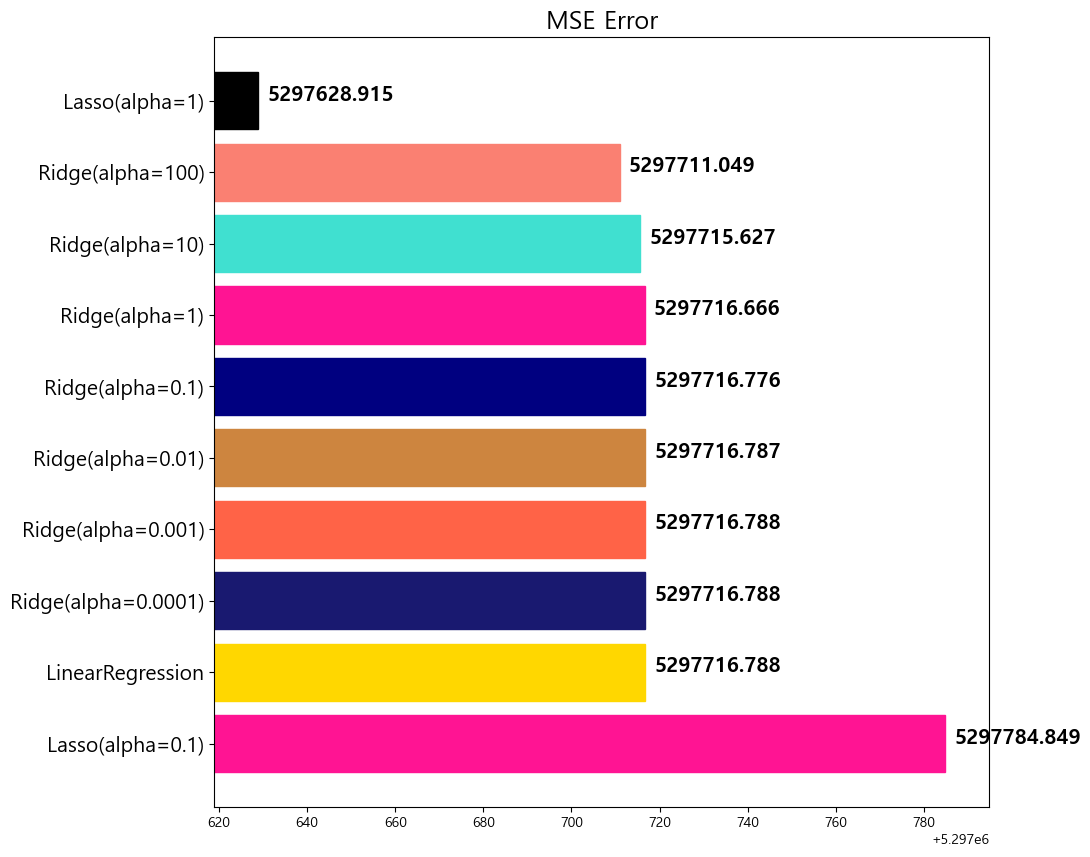

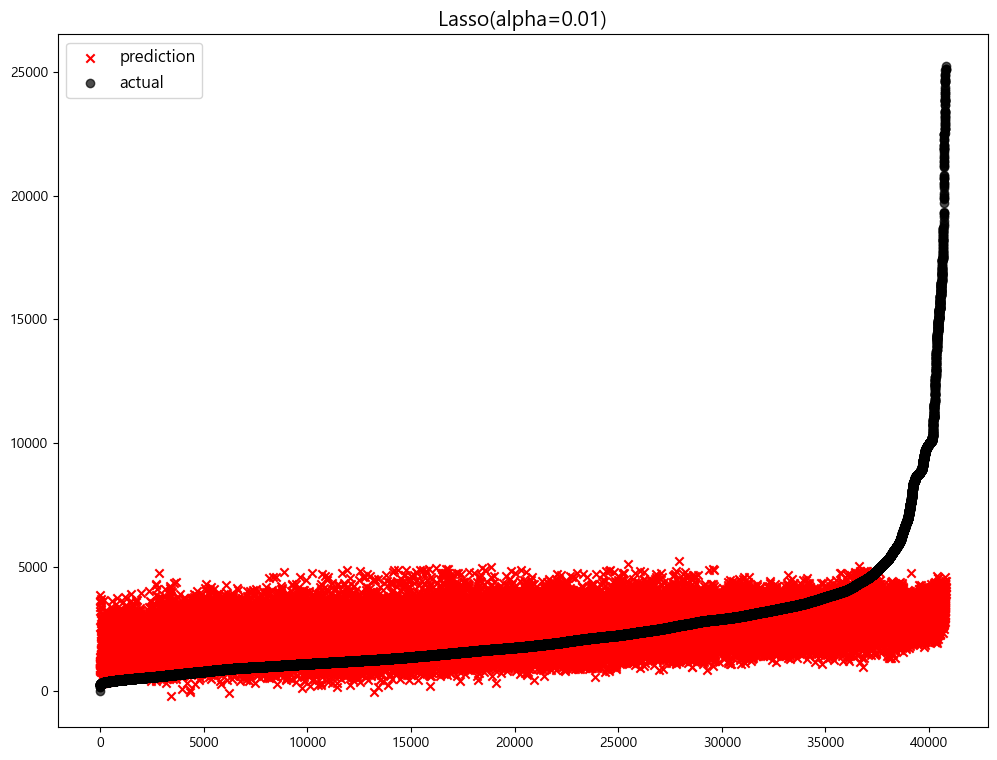

                  model           mse
0     Lasso(alpha=0.01)  5.297807e+06
1      Lasso(alpha=0.1)  5.297785e+06
2      LinearRegression  5.297717e+06
3   Ridge(alpha=0.0001)  5.297717e+06
4    Ridge(alpha=0.001)  5.297717e+06
5     Ridge(alpha=0.01)  5.297717e+06
6      Ridge(alpha=0.1)  5.297717e+06
7        Ridge(alpha=1)  5.297717e+06
8       Ridge(alpha=10)  5.297716e+06
9      Ridge(alpha=100)  5.297711e+06
10       Lasso(alpha=1)  5.297629e+06


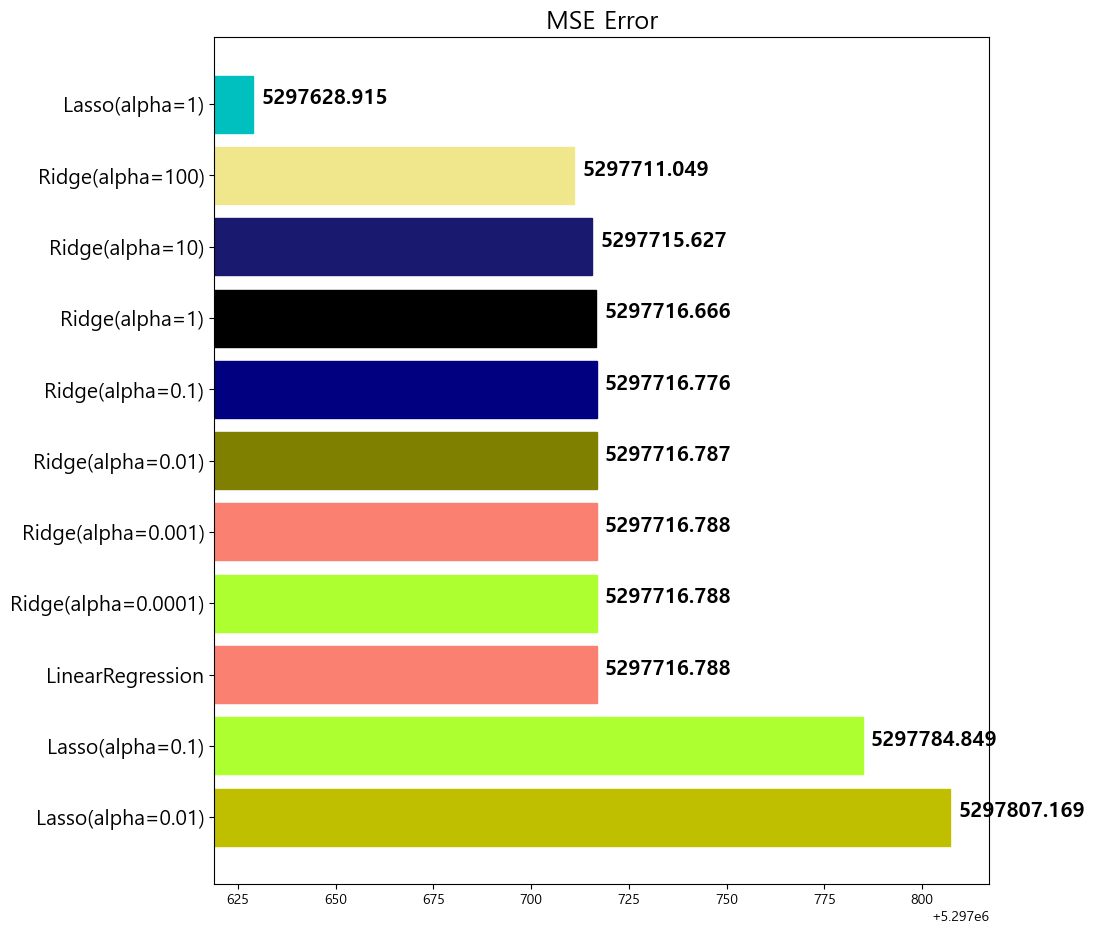

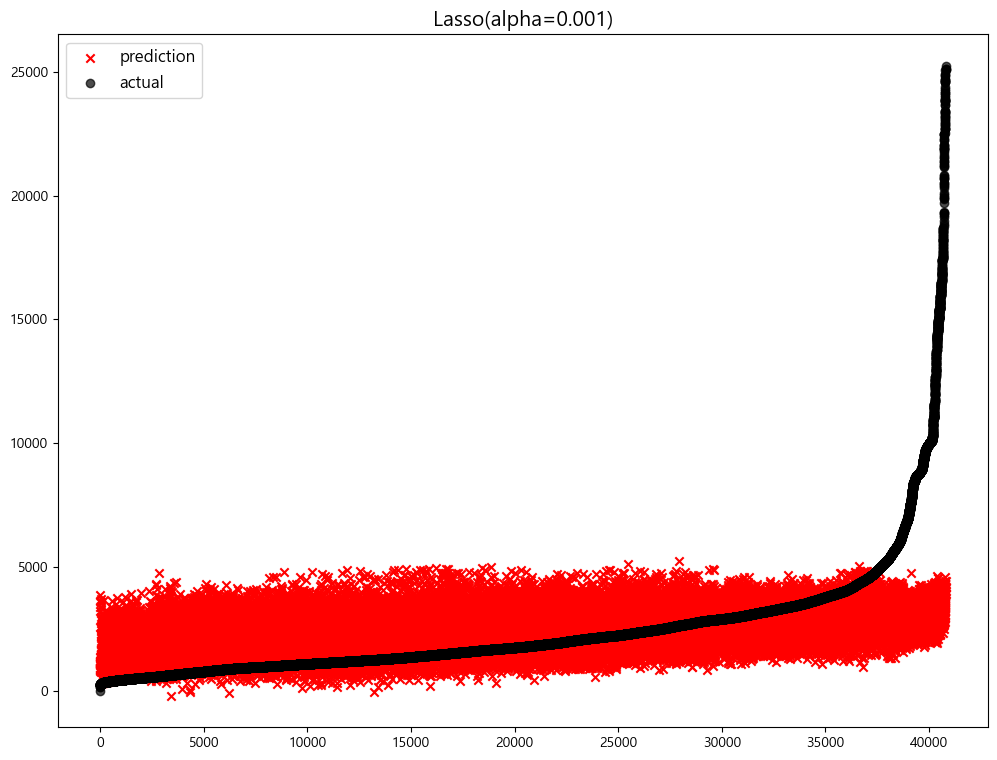

                  model           mse
0    Lasso(alpha=0.001)  5.297809e+06
1     Lasso(alpha=0.01)  5.297807e+06
2      Lasso(alpha=0.1)  5.297785e+06
3      LinearRegression  5.297717e+06
4   Ridge(alpha=0.0001)  5.297717e+06
5    Ridge(alpha=0.001)  5.297717e+06
6     Ridge(alpha=0.01)  5.297717e+06
7      Ridge(alpha=0.1)  5.297717e+06
8        Ridge(alpha=1)  5.297717e+06
9       Ridge(alpha=10)  5.297716e+06
10     Ridge(alpha=100)  5.297711e+06
11       Lasso(alpha=1)  5.297629e+06


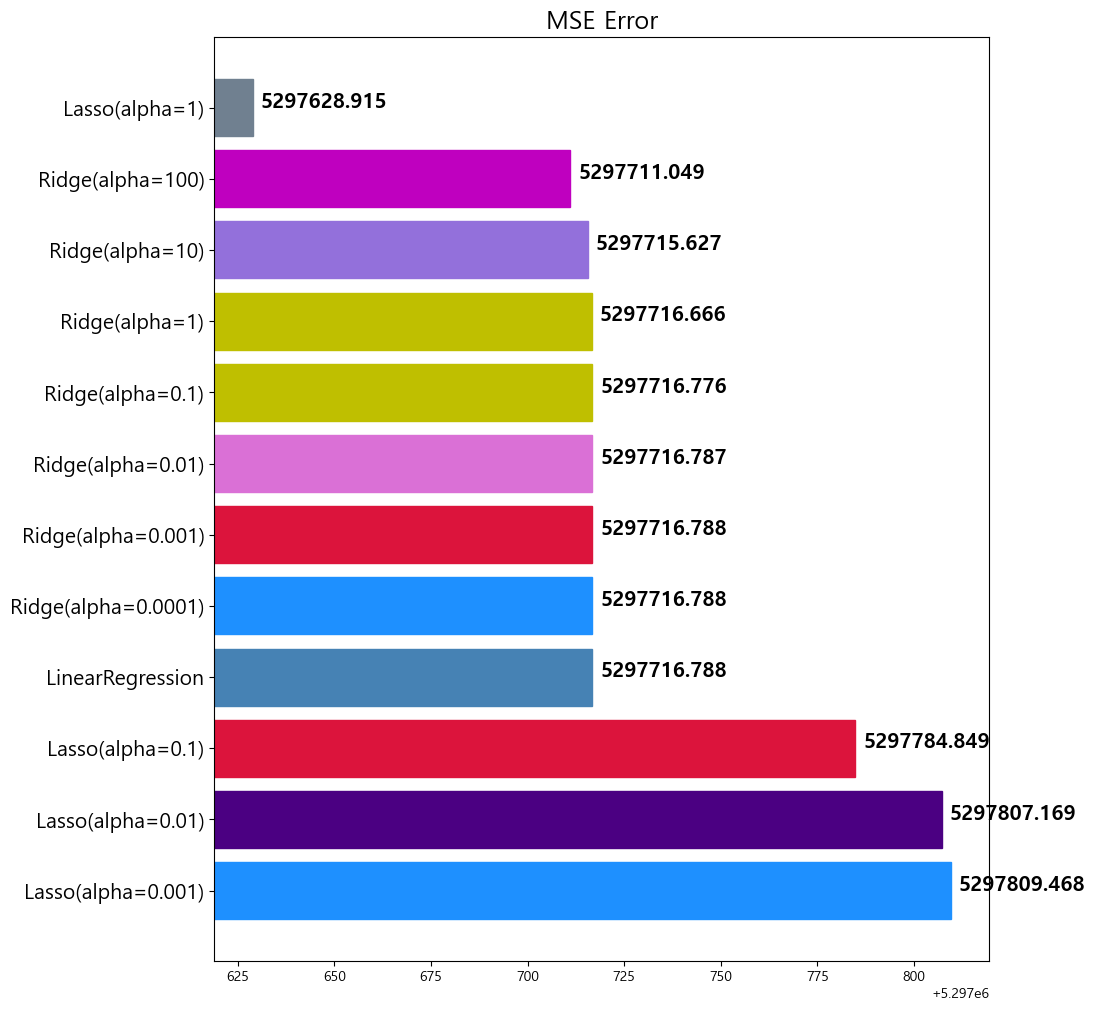

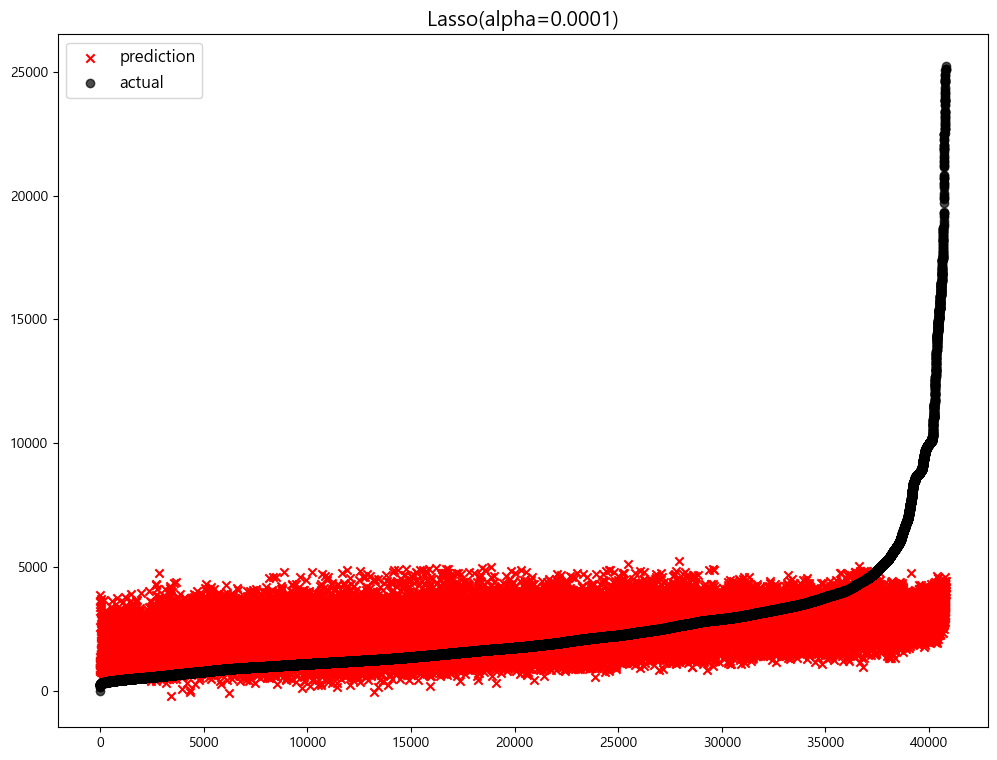

                  model           mse
0   Lasso(alpha=0.0001)  5.297810e+06
1    Lasso(alpha=0.001)  5.297809e+06
2     Lasso(alpha=0.01)  5.297807e+06
3      Lasso(alpha=0.1)  5.297785e+06
4      LinearRegression  5.297717e+06
5   Ridge(alpha=0.0001)  5.297717e+06
6    Ridge(alpha=0.001)  5.297717e+06
7     Ridge(alpha=0.01)  5.297717e+06
8      Ridge(alpha=0.1)  5.297717e+06
9        Ridge(alpha=1)  5.297717e+06
10      Ridge(alpha=10)  5.297716e+06
11     Ridge(alpha=100)  5.297711e+06
12       Lasso(alpha=1)  5.297629e+06


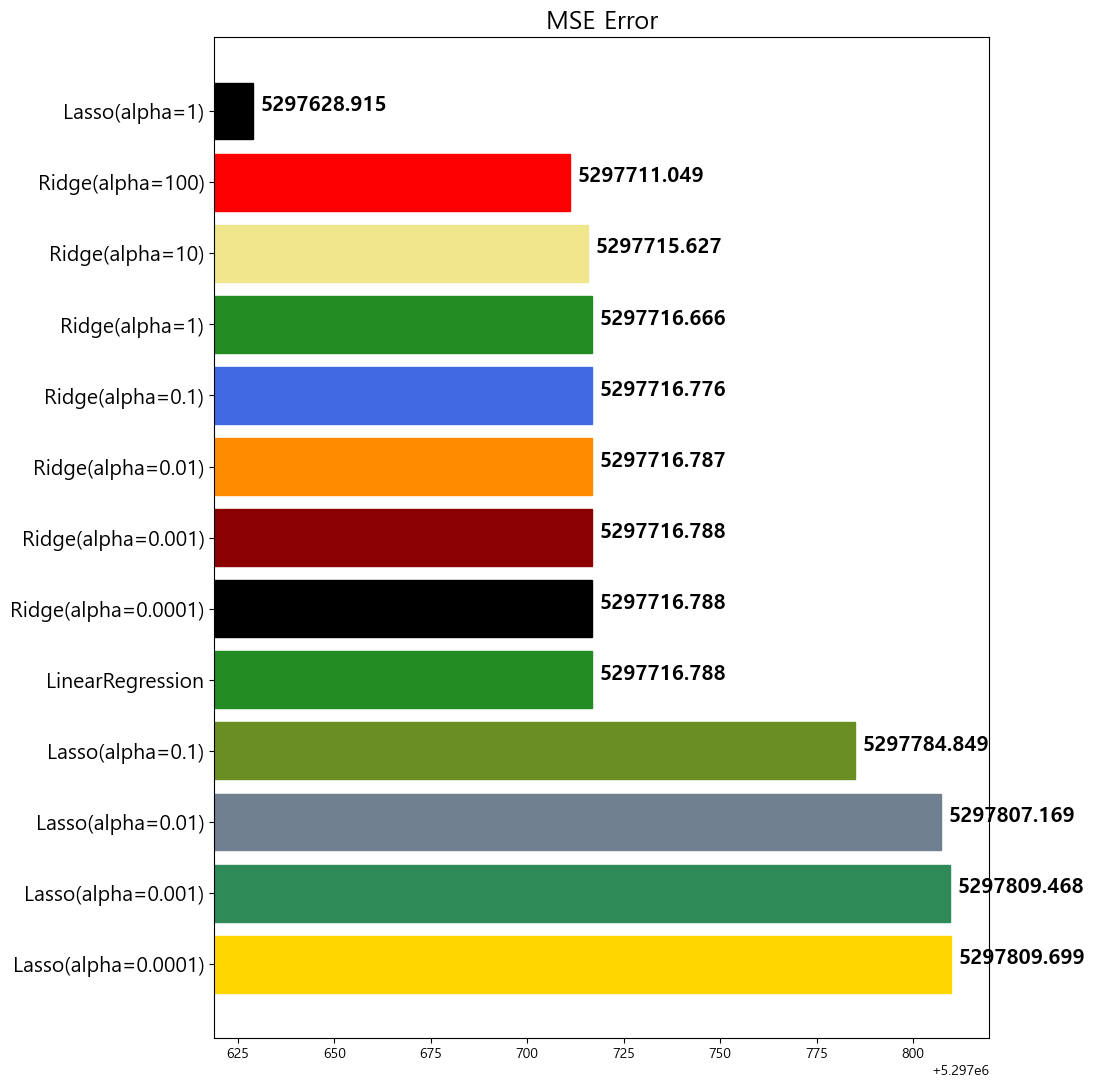

In [94]:
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)
    pred = lasso.predict(x_test)
    mse_eval('Lasso(alpha={})'.format(alpha), pred, y_test)

#### Lasso 1값을 적용

In [95]:
# Lasso에 alpha 값 1을 적용
lasso = Lasso(alpha=1)
lasso_pred = lasso.fit(x_train, y_train).predict(x_test)

#### elasticnet

In [96]:
# ratios가 수식의 r이다.
ratios = [0.2, 0.5, 0.8]

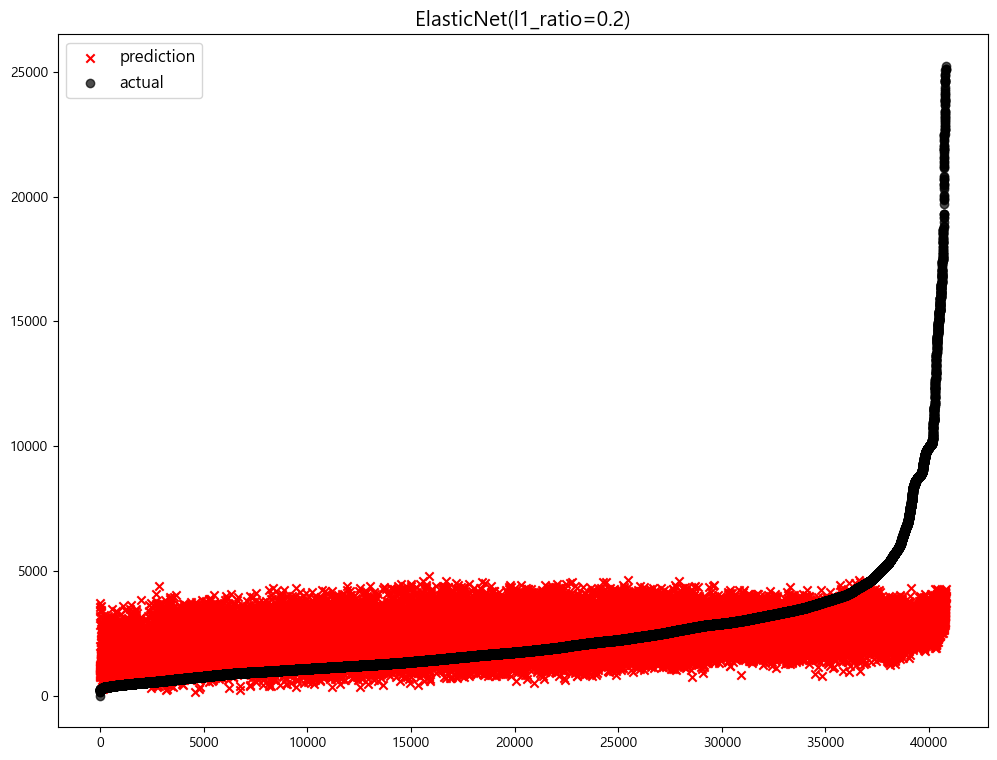

                       model           mse
0   ElasticNet(l1_ratio=0.2)  5.340955e+06
1        Lasso(alpha=0.0001)  5.297810e+06
2         Lasso(alpha=0.001)  5.297809e+06
3          Lasso(alpha=0.01)  5.297807e+06
4           Lasso(alpha=0.1)  5.297785e+06
5           LinearRegression  5.297717e+06
6        Ridge(alpha=0.0001)  5.297717e+06
7         Ridge(alpha=0.001)  5.297717e+06
8          Ridge(alpha=0.01)  5.297717e+06
9           Ridge(alpha=0.1)  5.297717e+06
10            Ridge(alpha=1)  5.297717e+06
11           Ridge(alpha=10)  5.297716e+06
12          Ridge(alpha=100)  5.297711e+06
13            Lasso(alpha=1)  5.297629e+06


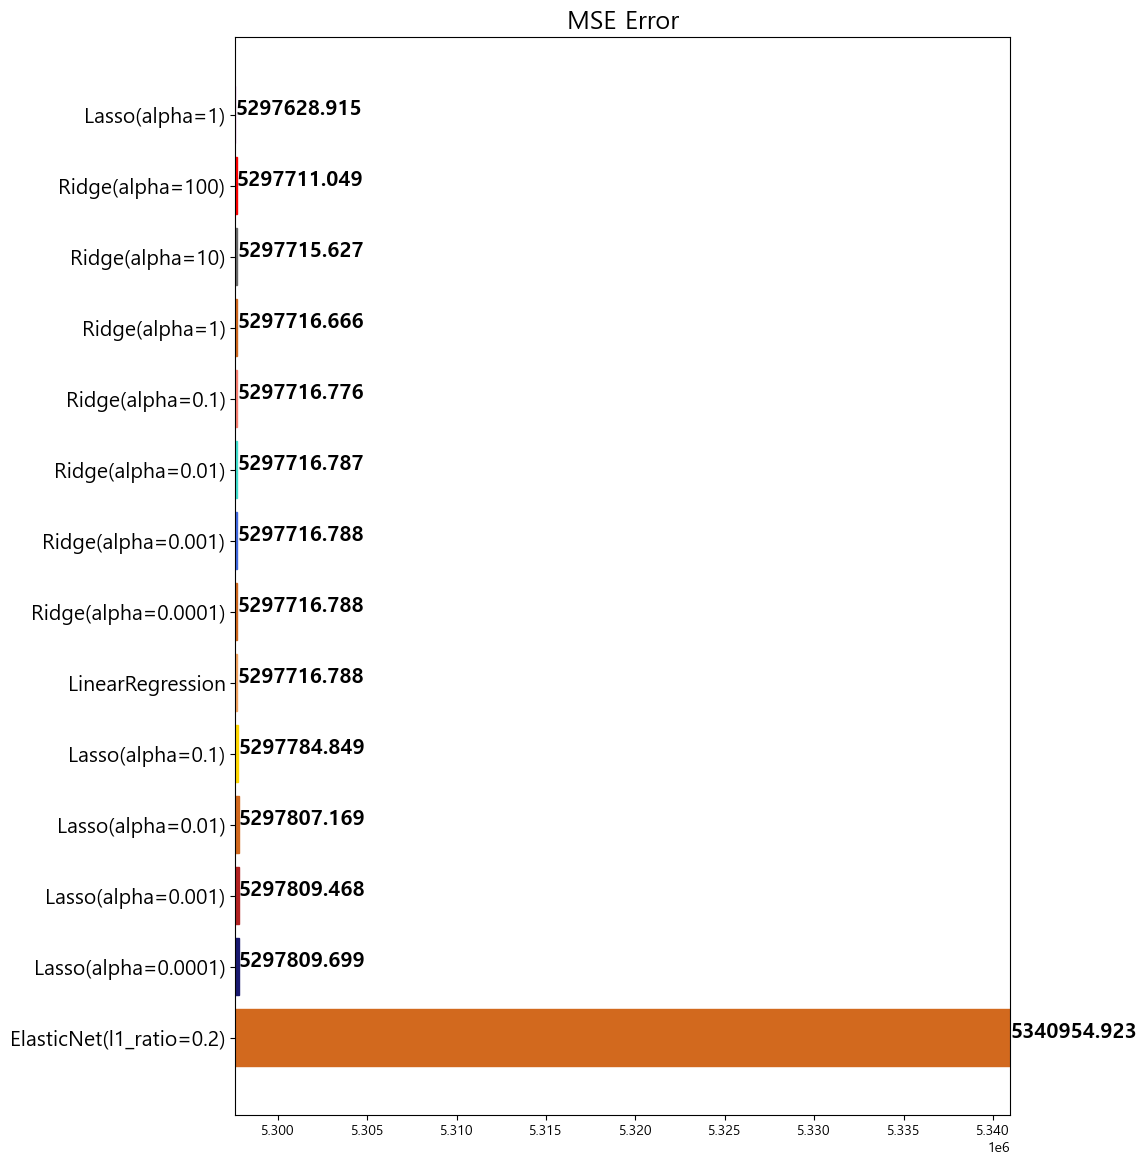

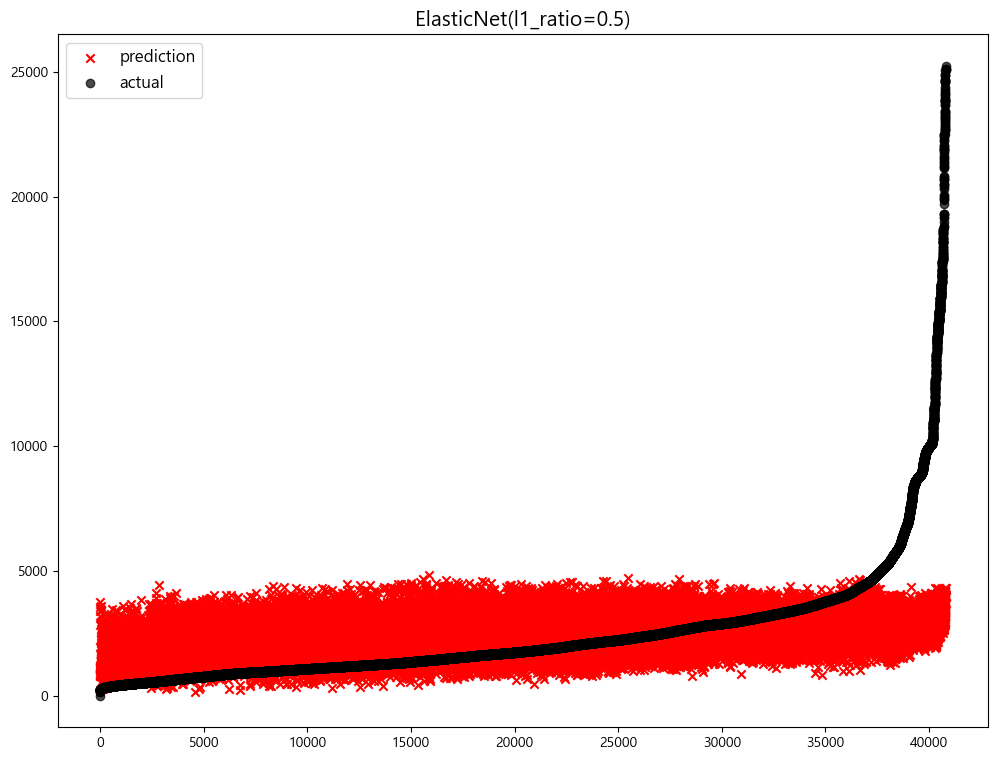

                       model           mse
0   ElasticNet(l1_ratio=0.2)  5.340955e+06
1   ElasticNet(l1_ratio=0.5)  5.332145e+06
2        Lasso(alpha=0.0001)  5.297810e+06
3         Lasso(alpha=0.001)  5.297809e+06
4          Lasso(alpha=0.01)  5.297807e+06
5           Lasso(alpha=0.1)  5.297785e+06
6           LinearRegression  5.297717e+06
7        Ridge(alpha=0.0001)  5.297717e+06
8         Ridge(alpha=0.001)  5.297717e+06
9          Ridge(alpha=0.01)  5.297717e+06
10          Ridge(alpha=0.1)  5.297717e+06
11            Ridge(alpha=1)  5.297717e+06
12           Ridge(alpha=10)  5.297716e+06
13          Ridge(alpha=100)  5.297711e+06
14            Lasso(alpha=1)  5.297629e+06


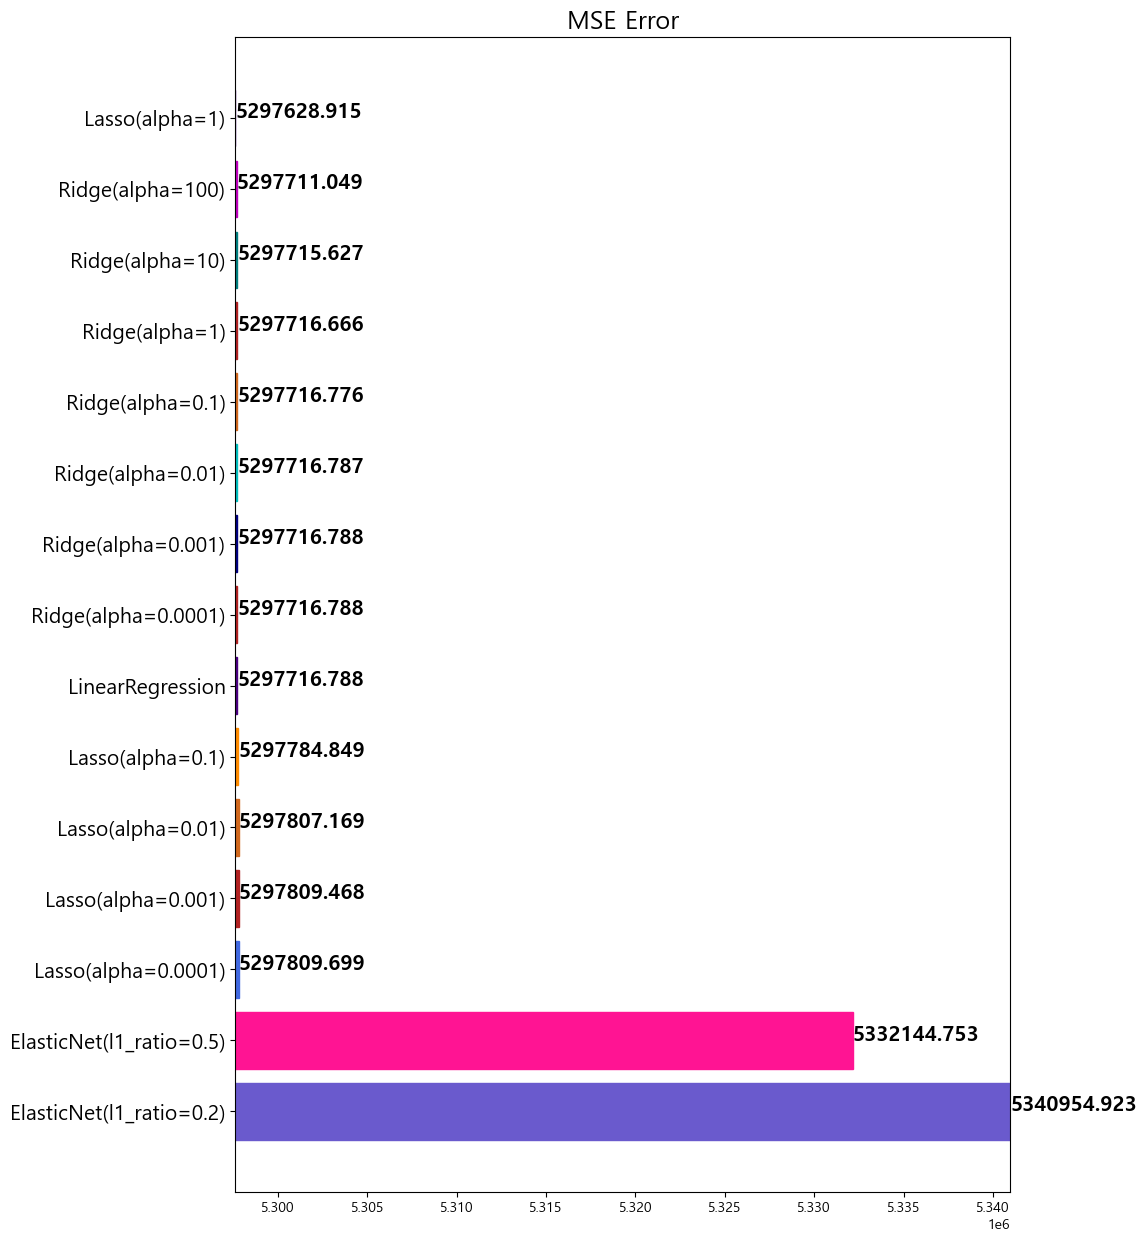

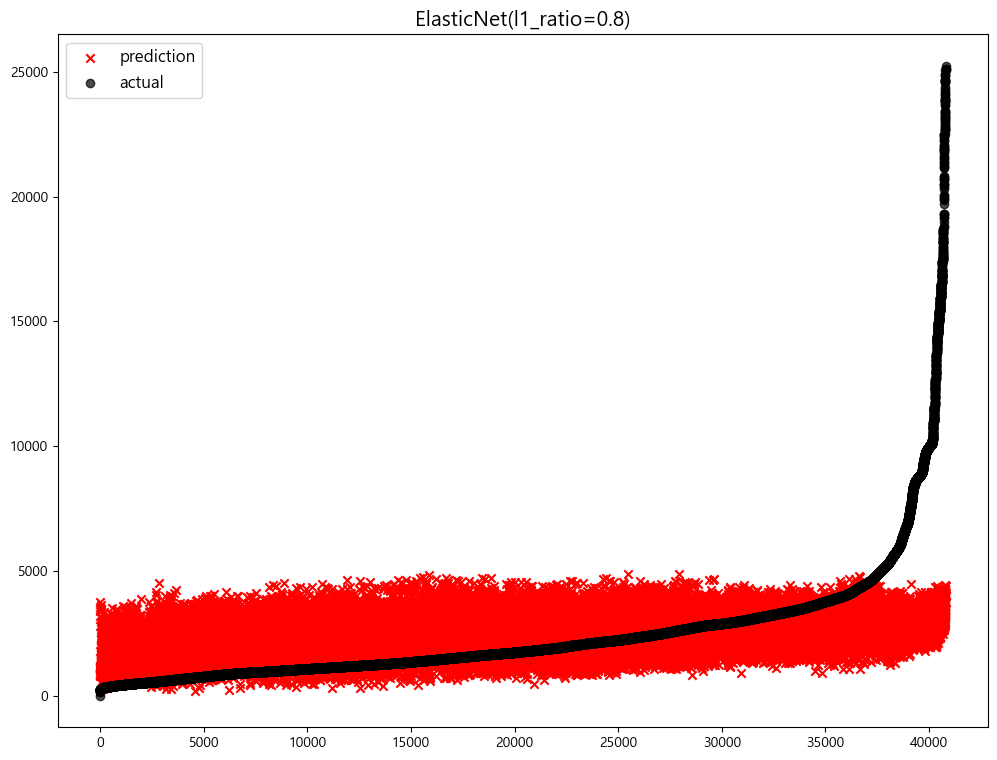

                       model           mse
0   ElasticNet(l1_ratio=0.2)  5.340955e+06
1   ElasticNet(l1_ratio=0.5)  5.332145e+06
2   ElasticNet(l1_ratio=0.8)  5.317048e+06
3        Lasso(alpha=0.0001)  5.297810e+06
4         Lasso(alpha=0.001)  5.297809e+06
5          Lasso(alpha=0.01)  5.297807e+06
6           Lasso(alpha=0.1)  5.297785e+06
7           LinearRegression  5.297717e+06
8        Ridge(alpha=0.0001)  5.297717e+06
9         Ridge(alpha=0.001)  5.297717e+06
10         Ridge(alpha=0.01)  5.297717e+06
11          Ridge(alpha=0.1)  5.297717e+06
12            Ridge(alpha=1)  5.297717e+06
13           Ridge(alpha=10)  5.297716e+06
14          Ridge(alpha=100)  5.297711e+06
15            Lasso(alpha=1)  5.297629e+06


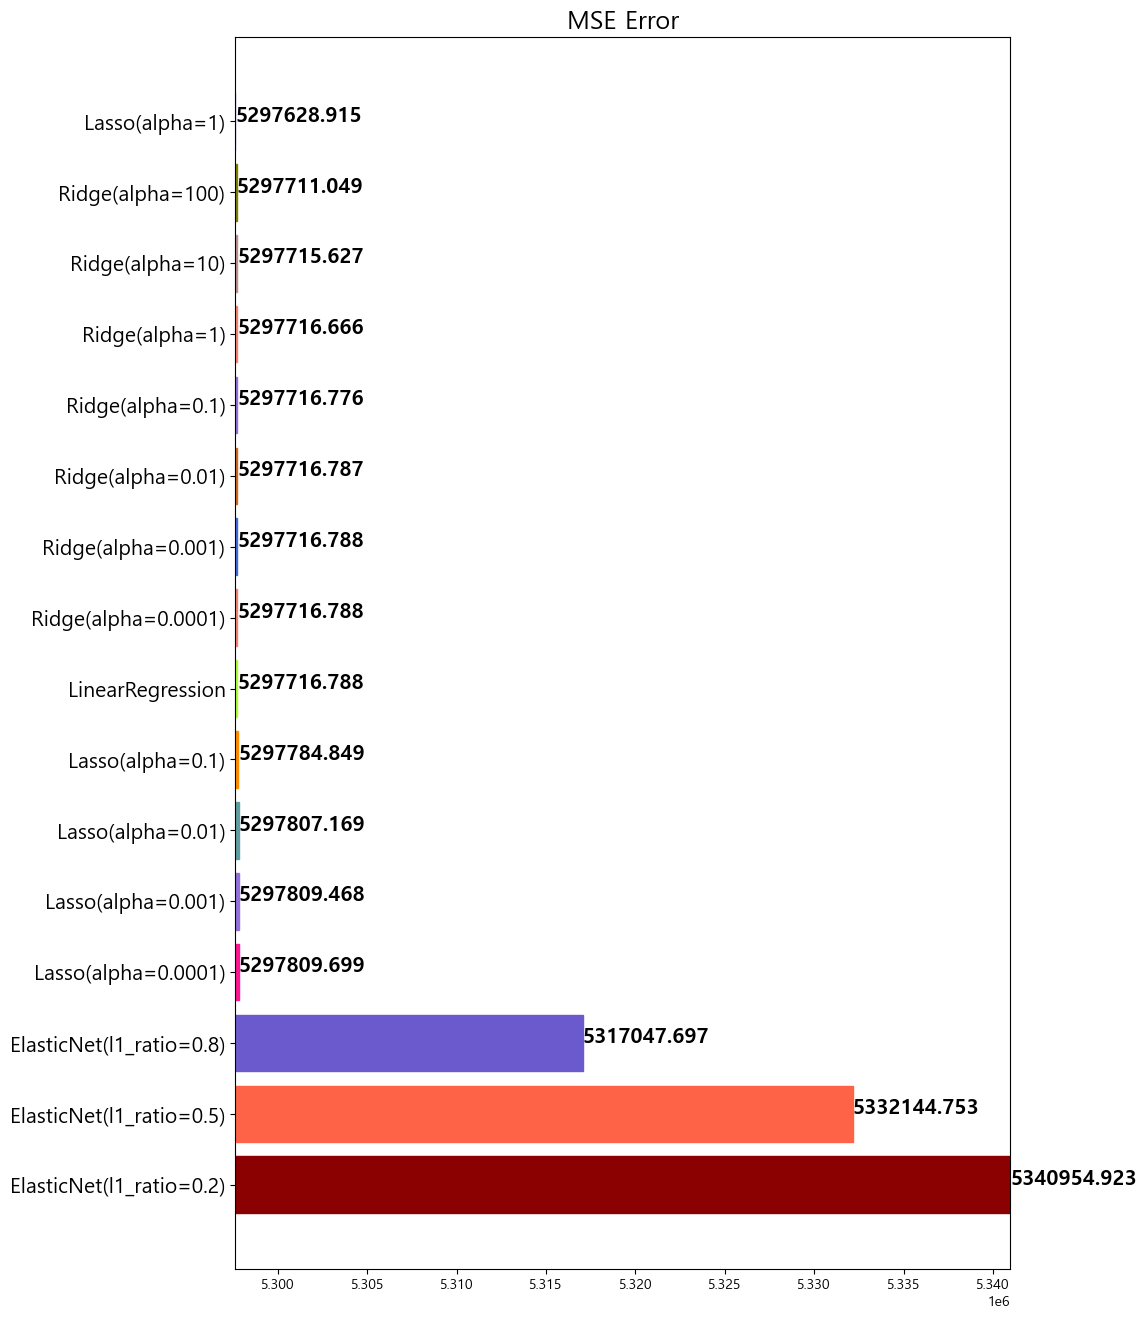

In [97]:
for ratio in ratios:
    elasticnet = ElasticNet(alpha=0.5, l1_ratio=ratio)
    elasticnet.fit(x_train, y_train)
    pred = elasticnet.predict(x_test)
    mse_eval('ElasticNet(l1_ratio={})'.format(ratio), pred, y_test)

#### ElasticNet에 0.8 적용

In [98]:
# ElasticNet에 Ratio 0.8 적용
elasticnet = ElasticNet(alpha=0.5, l1_ratio=0.8)
elasticnet_pred = elasticnet.fit(x_train, y_train).predict(x_test)

#### StandardScaler, MinMaxScaler, RobustScaler

In [99]:
std_scaler = StandardScaler()
std_scaled = std_scaler.fit_transform(x_train)
round(pd.DataFrame(std_scaled).describe(), 2)

0          1          2          3          4          5   \
count  163200.00  163200.00  163200.00  163200.00  163200.00  163200.00   
mean        0.00       0.00      -0.00      -0.00      -0.00      -0.00   
std         1.00       1.00       1.00       1.00       1.00       1.00   
min        -1.72      -4.08      -0.17      -1.57      -4.36      -0.59   
25%        -0.85      -0.57      -0.17      -0.69      -0.65      -0.59   
50%         0.02       0.04      -0.17      -0.10       0.15      -0.59   
75%         0.88       0.68      -0.17       0.49       0.81       0.25   
max         1.72       3.05      36.55       8.21       1.41       2.21   

              6         7          8          9          10         11  \
count  163200.00  163200.0  163200.00  163200.00  163200.00  163200.00   
mean        0.00       0.0      -0.00       0.00      -0.00      -0.00   
std         1.00       0.0       1.00       1.00       1.00       1.00   
min        -0.66       0.0      -1.17      -1.64      -1.66      -1.50   
25%        -0.66       0.0      -1.17      -0.81      -0.94      -1.00   
50%        -0.61       0.0       0.09       0.02       0.07       0.01   
75%         0.35       0.0       1.35       0.85       0.80       1.01   
max         3.60       0.0       1.35       1.91       1.66       1.51   

              12         13         14         15         16         17  \
count  163200.00  163200.00  163200.00  163200.00  163200.00  163200.00   
mean       -0.00       0.00      -0.00       0.00      -0.00       0.00   
std         1.00       1.00       1.00       1.00       1.00       1.00   
min        -4.56      -1.86      -1.43      -0.20      -0.17      -0.40   
25%        -0.52      -0.81      -0.88      -0.16      -0.15      -0.40   
50%         0.16       0.25      -0.05      -0.13      -0.12      -0.40   
75%         0.72       0.25       0.77      -0.06      -0.08      -0.06   
max         2.68       1.30       1.59       9.87       9.88       6.51   

              18         19  
count  163200.00  163200.00  
mean        0.00      -0.00  
std         1.00       1.00  
min        -0.20      -0.21  
25%        -0.20      -0.21  
50%        -0.20      -0.21  
75%        -0.20      -0.21  
max         6.98       6.63

In [100]:
minmax_scaler = MinMaxScaler()
minmax_scaled = minmax_scaler.fit_transform(x_train)
round(pd.DataFrame(minmax_scaled).describe(), 2)

0          1          2          3          4          5   \
count  163200.00  163200.00  163200.00  163200.00  163200.00  163200.00   
mean        0.50       0.57       0.00       0.16       0.76       0.21   
std         0.29       0.14       0.03       0.10       0.17       0.36   
min         0.00       0.00       0.00       0.00       0.00       0.00   
25%         0.25       0.49       0.00       0.09       0.64       0.00   
50%         0.51       0.58       0.00       0.15       0.78       0.00   
75%         0.76       0.67       0.00       0.21       0.90       0.30   
max         1.00       1.00       1.00       1.00       1.00       1.00   

              6         7          8          9          10         11  \
count  163200.00  163200.0  163200.00  163200.00  163200.00  163200.00   
mean        0.15       0.0       0.47       0.46       0.50       0.50   
std         0.23       0.0       0.40       0.28       0.30       0.33   
min         0.00       0.0       0.00       0.00       0.00       0.00   
25%         0.00       0.0       0.00       0.23       0.22       0.17   
50%         0.01       0.0       0.50       0.47       0.52       0.50   
75%         0.24       0.0       1.00       0.70       0.74       0.83   
max         1.00       0.0       1.00       1.00       1.00       1.00   

              12         13         14         15         16         17  \
count  163200.00  163200.00  163200.00  163200.00  163200.00  163200.00   
mean        0.63       0.59       0.47       0.02       0.02       0.06   
std         0.14       0.32       0.33       0.10       0.10       0.14   
min         0.00       0.00       0.00       0.00       0.00       0.00   
25%         0.56       0.33       0.18       0.00       0.00       0.00   
50%         0.65       0.67       0.45       0.01       0.01       0.00   
75%         0.73       0.67       0.73       0.01       0.01       0.05   
max         1.00       1.00       1.00       1.00       1.00       1.00   

              18         19  
count  163200.00  163200.00  
mean        0.03       0.03  
std         0.14       0.15  
min         0.00       0.00  
25%         0.00       0.00  
50%         0.00       0.00  
75%         0.00       0.00  
max         1.00       1.00

In [101]:
robust_scaler = RobustScaler()
robust_scaled = robust_scaler.fit_transform(x_train)
round(pd.DataFrame(robust_scaled).median(), 2)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
dtype: float64

#### elasticnet_pipeline

In [102]:
elasticnet_pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.5, l1_ratio=0.8)
)

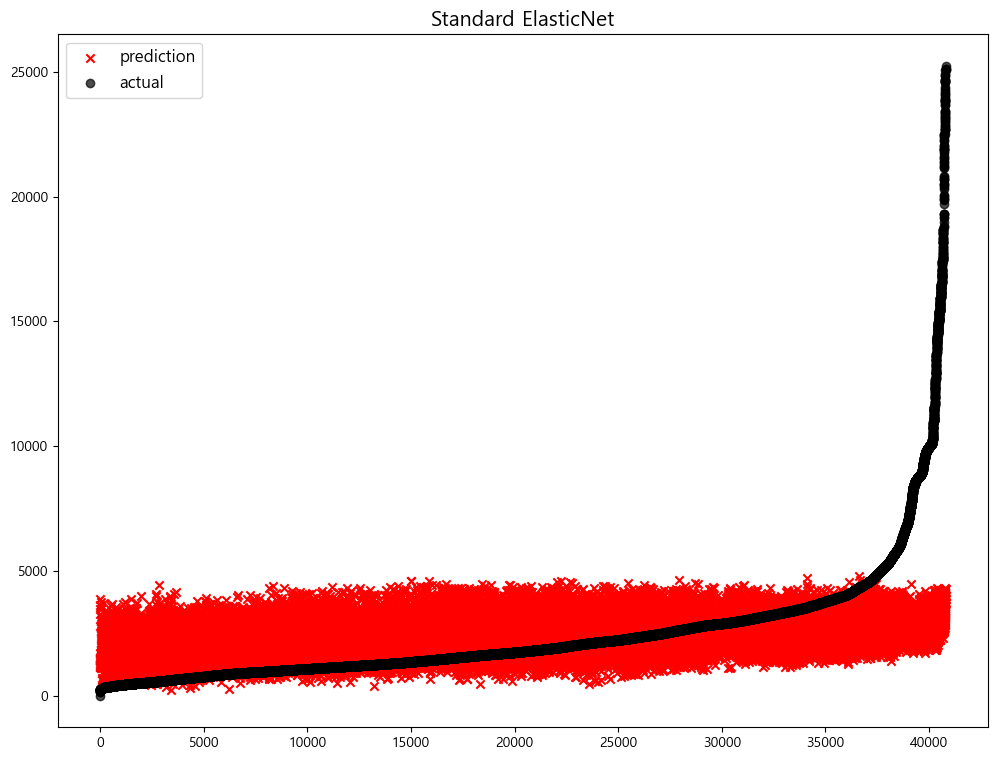

                       model           mse
0        Standard ElasticNet  5.343432e+06
1   ElasticNet(l1_ratio=0.2)  5.340955e+06
2   ElasticNet(l1_ratio=0.5)  5.332145e+06
3   ElasticNet(l1_ratio=0.8)  5.317048e+06
4        Lasso(alpha=0.0001)  5.297810e+06
5         Lasso(alpha=0.001)  5.297809e+06
6          Lasso(alpha=0.01)  5.297807e+06
7           Lasso(alpha=0.1)  5.297785e+06
8           LinearRegression  5.297717e+06
9        Ridge(alpha=0.0001)  5.297717e+06
10        Ridge(alpha=0.001)  5.297717e+06
11         Ridge(alpha=0.01)  5.297717e+06
12          Ridge(alpha=0.1)  5.297717e+06
13            Ridge(alpha=1)  5.297717e+06
14           Ridge(alpha=10)  5.297716e+06
15          Ridge(alpha=100)  5.297711e+06
16            Lasso(alpha=1)  5.297629e+06


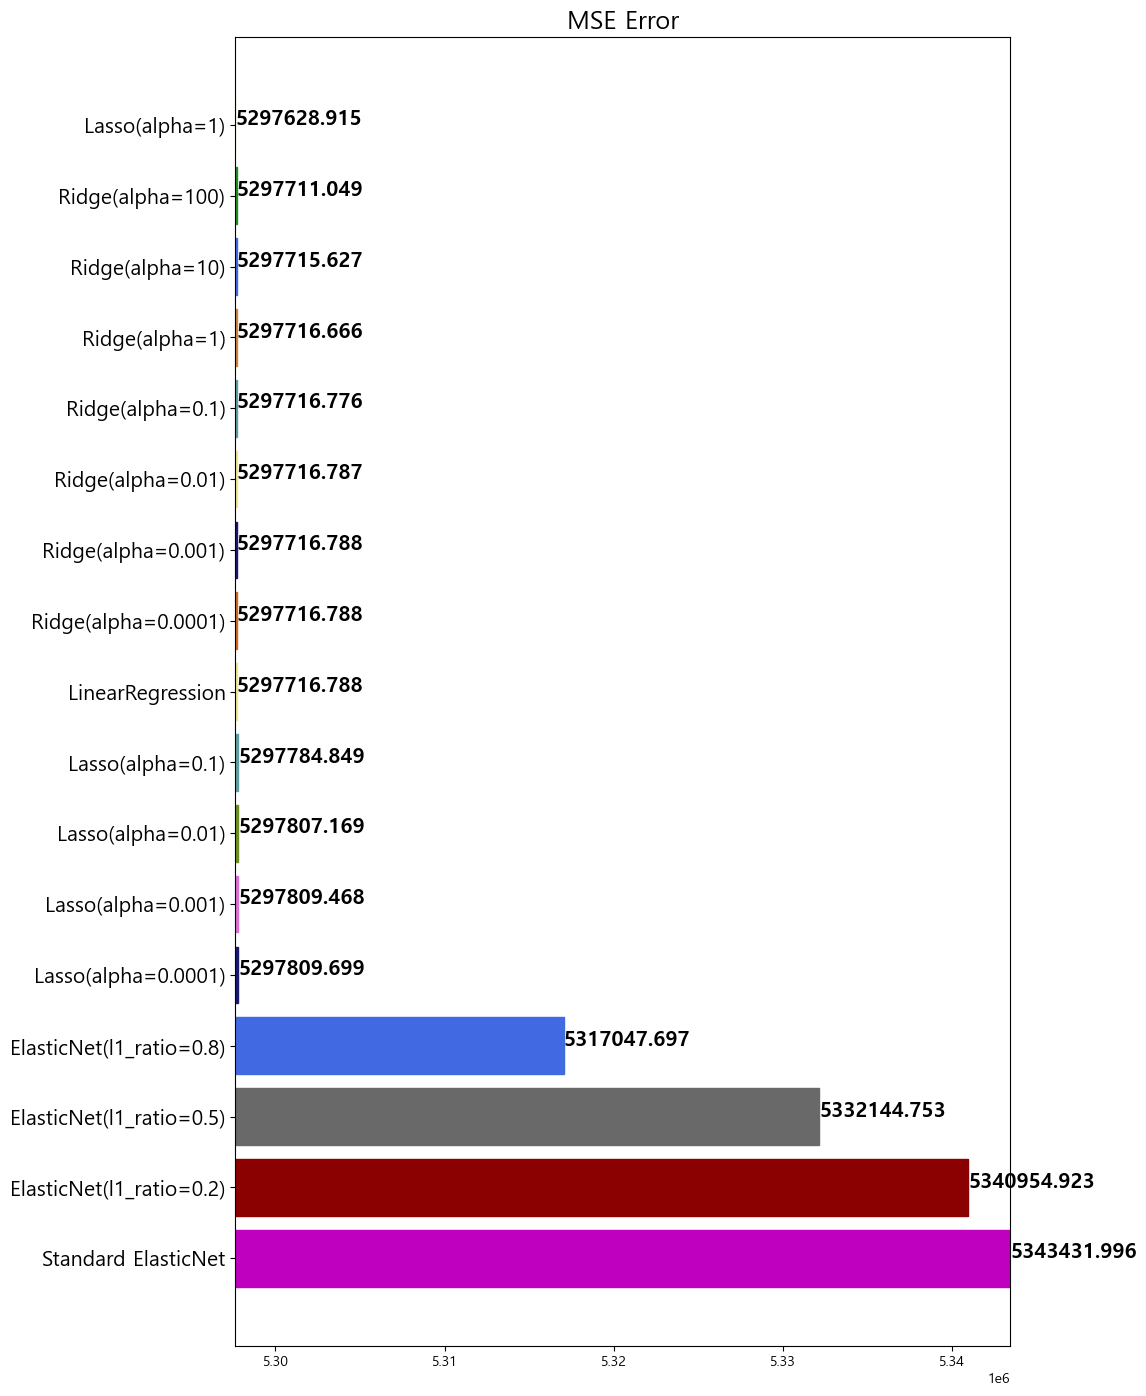

In [103]:
elasticnet_pipeline.fit(x_train, y_train)
pred = elasticnet_pipeline.predict(x_test)
mse_eval('Standard ElasticNet', pred, y_test)

#### elasticnet_no_pipeline

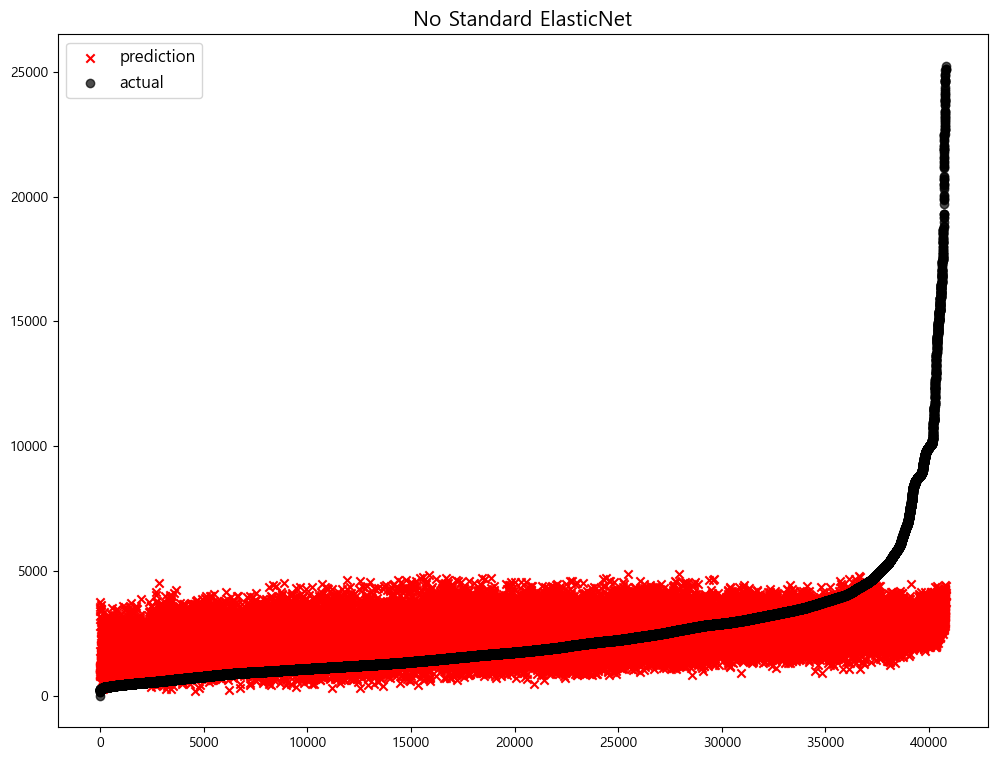

                       model           mse
0        Standard ElasticNet  5.343432e+06
1   ElasticNet(l1_ratio=0.2)  5.340955e+06
2   ElasticNet(l1_ratio=0.5)  5.332145e+06
3   ElasticNet(l1_ratio=0.8)  5.317048e+06
4     No Standard ElasticNet  5.317048e+06
5        Lasso(alpha=0.0001)  5.297810e+06
6         Lasso(alpha=0.001)  5.297809e+06
7          Lasso(alpha=0.01)  5.297807e+06
8           Lasso(alpha=0.1)  5.297785e+06
9           LinearRegression  5.297717e+06
10       Ridge(alpha=0.0001)  5.297717e+06
11        Ridge(alpha=0.001)  5.297717e+06
12         Ridge(alpha=0.01)  5.297717e+06
13          Ridge(alpha=0.1)  5.297717e+06
14            Ridge(alpha=1)  5.297717e+06
15           Ridge(alpha=10)  5.297716e+06
16          Ridge(alpha=100)  5.297711e+06
17            Lasso(alpha=1)  5.297629e+06


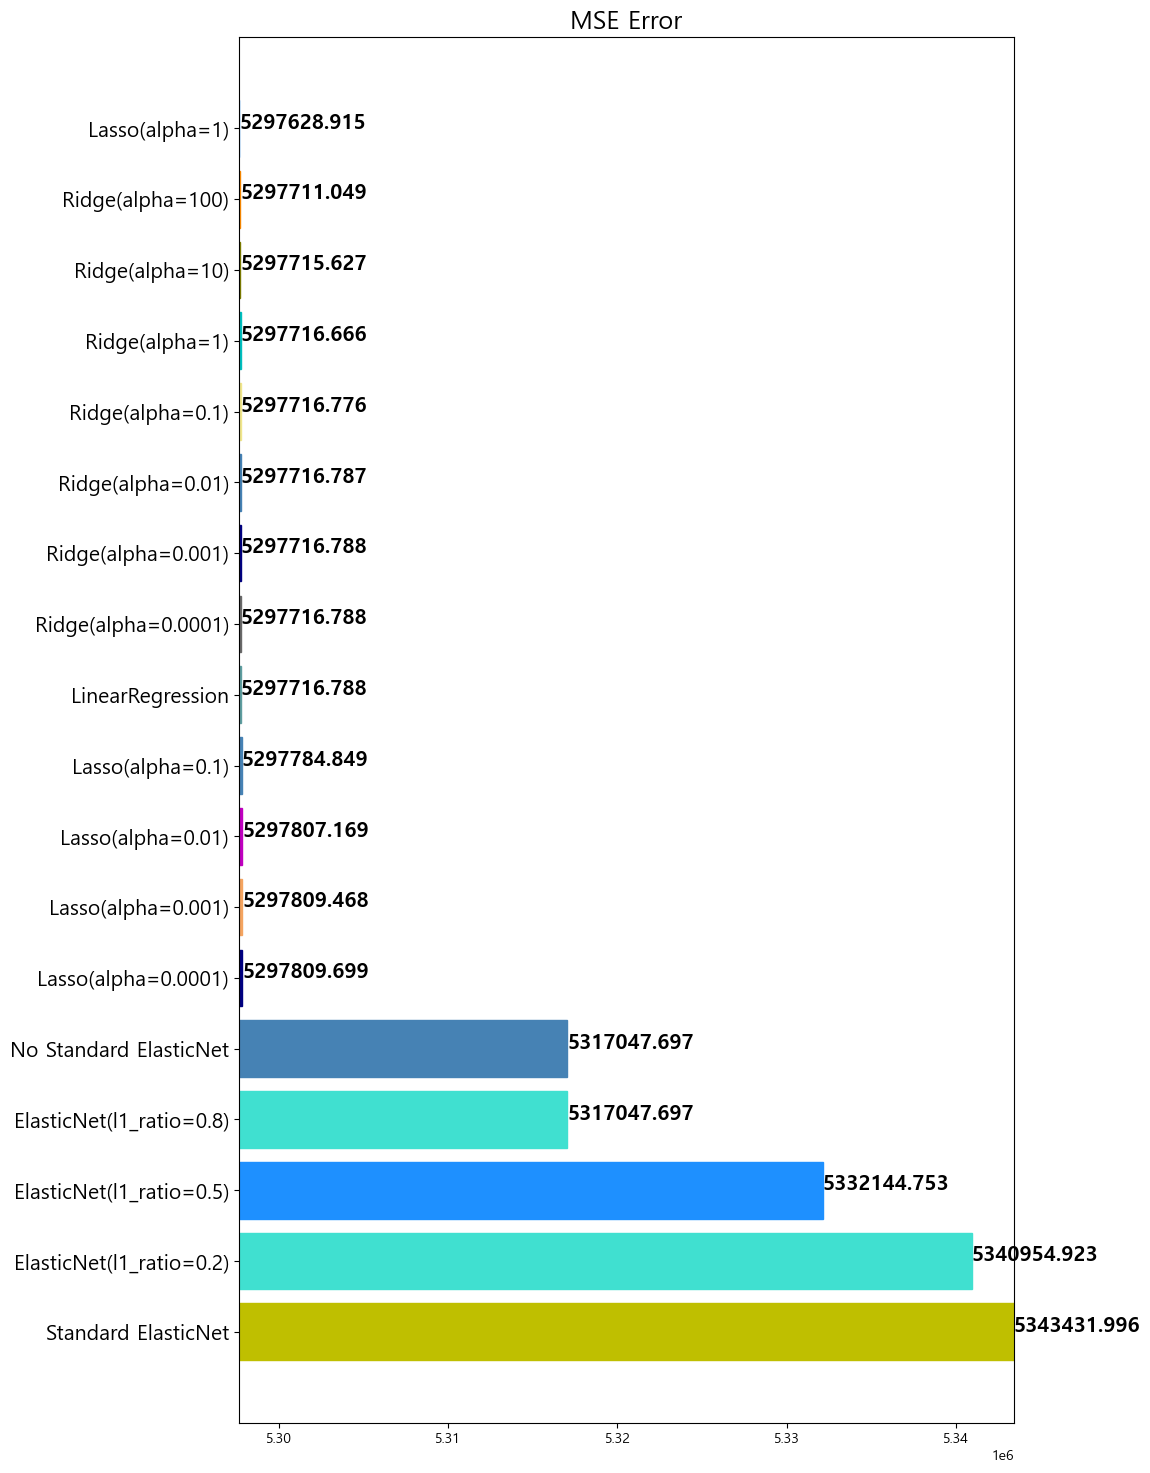

In [104]:
elasticnet_no_pipeline = ElasticNet(alpha=0.5, l1_ratio=0.8)
no_pipelline_pred = elasticnet_no_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('No Standard ElasticNet', no_pipelline_pred, y_test)

#### Polynomial Features

In [105]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(x_train)

In [106]:
poly_features

array([5.50000000e+01, 2.26000000e+01, 0.00000000e+00, 1.30000000e+00,
       9.90000000e+01, 0.00000000e+00, 0.00000000e+00, 2.02200000e+03,
       7.00000000e+00, 2.20000000e+01, 1.00000000e+00, 4.00000000e+00,
       7.25992600e+01, 2.00000000e+00, 6.00000000e+00, 2.53418700e+04,
       1.30401000e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.02500000e+03, 1.24300000e+03, 0.00000000e+00, 7.15000000e+01,
       5.44500000e+03, 0.00000000e+00, 0.00000000e+00, 1.11210000e+05,
       3.85000000e+02, 1.21000000e+03, 5.50000000e+01, 2.20000000e+02,
       3.99295930e+03, 1.10000000e+02, 3.30000000e+02, 1.39380285e+06,
       7.17205500e+05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.10760000e+02, 0.00000000e+00, 2.93800000e+01, 2.23740000e+03,
       0.00000000e+00, 0.00000000e+00, 4.56972000e+04, 1.58200000e+02,
       4.97200000e+02, 2.26000000e+01, 9.04000000e+01, 1.64074328e+03,
       4.52000000e+01, 1.35600000e+02, 5.72726262e+05, 2.94706260e+05,
      

In [107]:
poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    StandardScaler(),
    ElasticNet(alpha=0.5, l1_ratio=0.8)
)

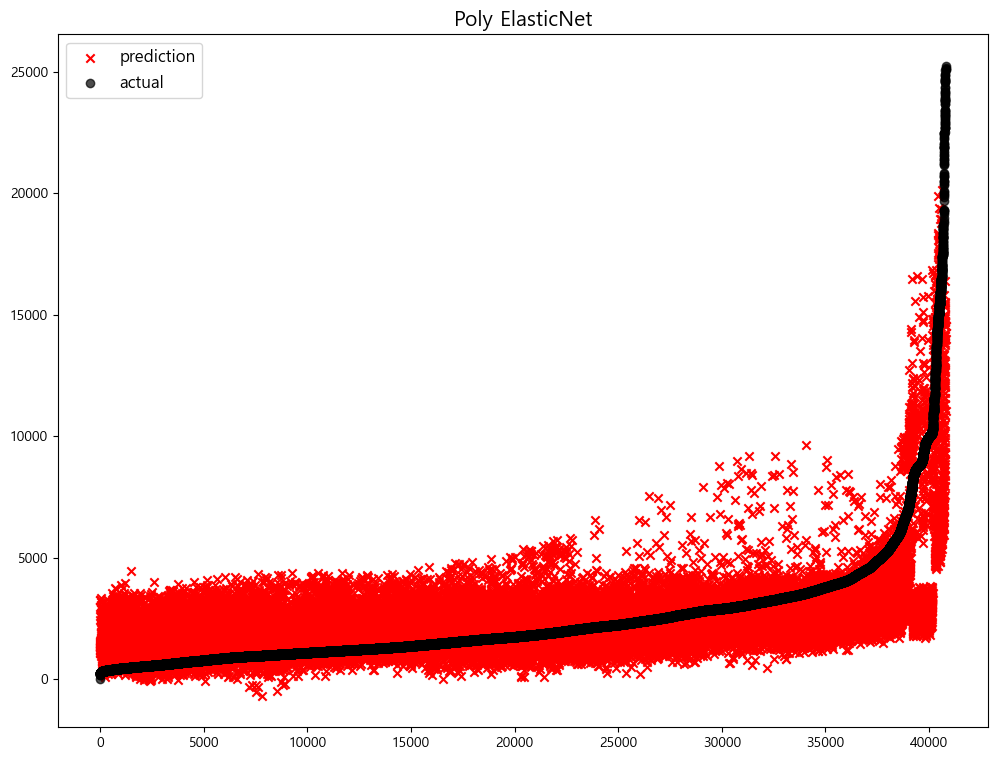

                       model           mse
0        Standard ElasticNet  5.343432e+06
1   ElasticNet(l1_ratio=0.2)  5.340955e+06
2   ElasticNet(l1_ratio=0.5)  5.332145e+06
3   ElasticNet(l1_ratio=0.8)  5.317048e+06
4     No Standard ElasticNet  5.317048e+06
5        Lasso(alpha=0.0001)  5.297810e+06
6         Lasso(alpha=0.001)  5.297809e+06
7          Lasso(alpha=0.01)  5.297807e+06
8           Lasso(alpha=0.1)  5.297785e+06
9           LinearRegression  5.297717e+06
10       Ridge(alpha=0.0001)  5.297717e+06
11        Ridge(alpha=0.001)  5.297717e+06
12         Ridge(alpha=0.01)  5.297717e+06
13          Ridge(alpha=0.1)  5.297717e+06
14            Ridge(alpha=1)  5.297717e+06
15           Ridge(alpha=10)  5.297716e+06
16          Ridge(alpha=100)  5.297711e+06
17            Lasso(alpha=1)  5.297629e+06
18           Poly ElasticNet  3.085862e+06


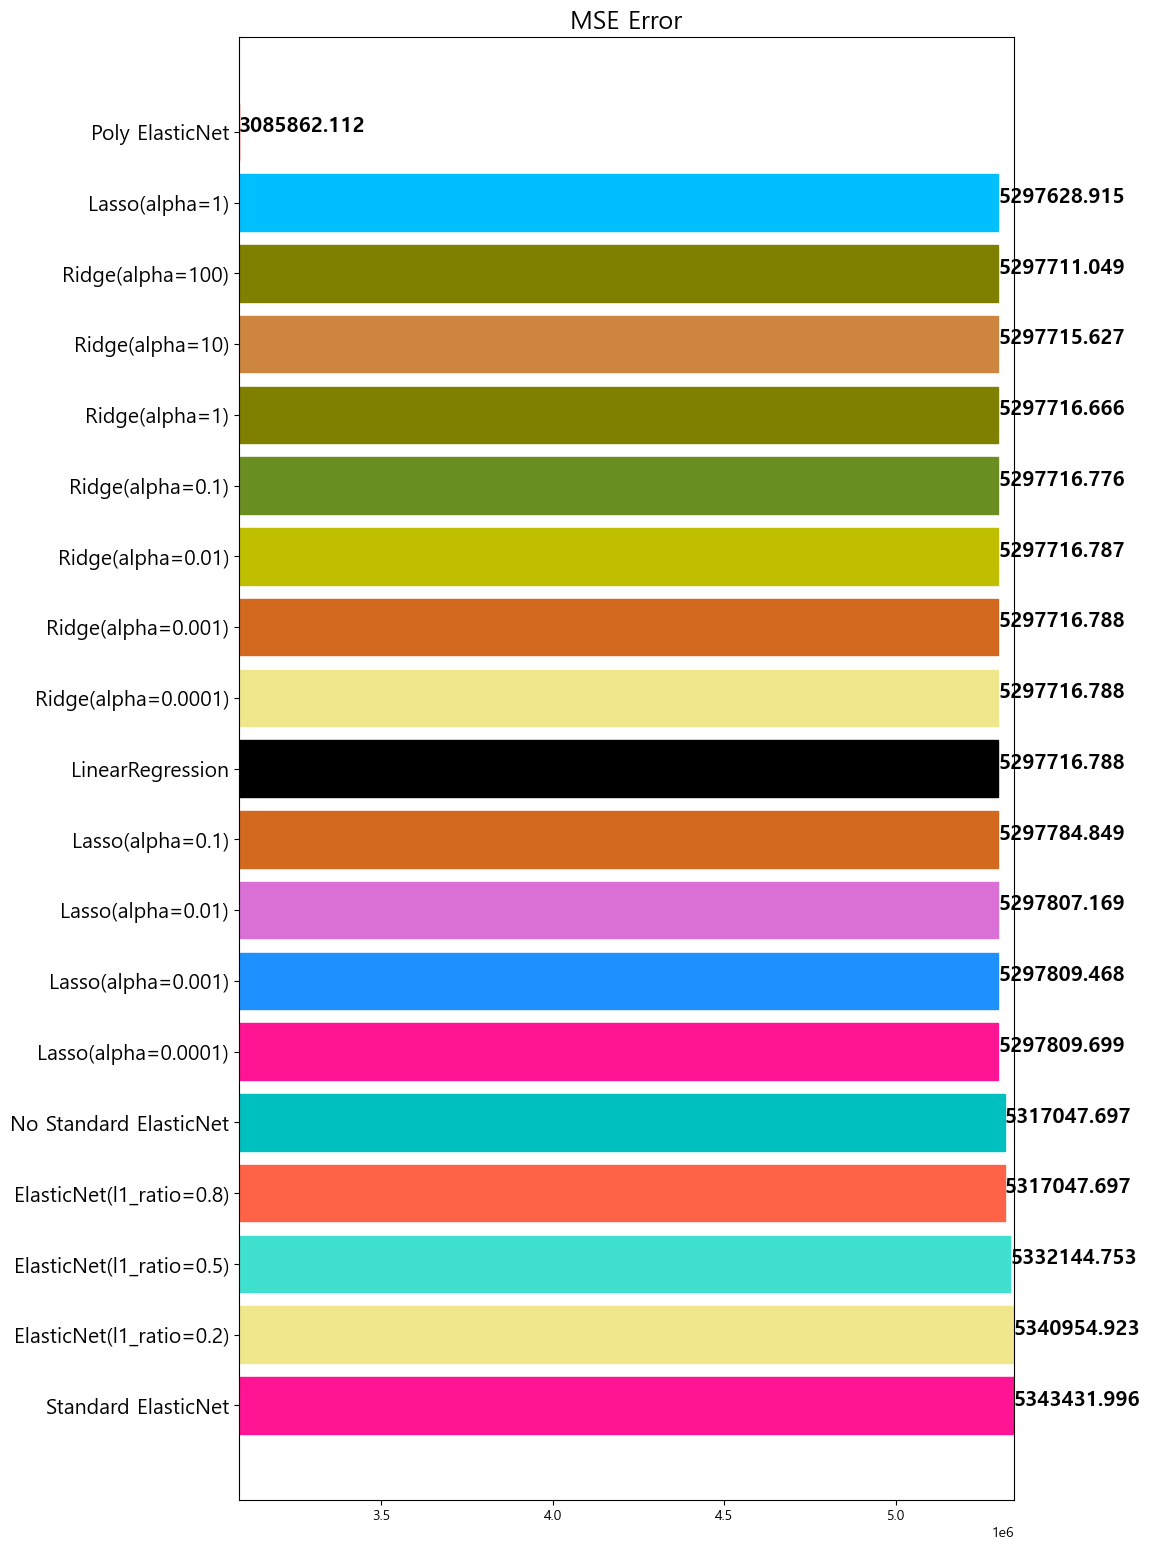

In [108]:
poly_pred = poly_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('Poly ElasticNet', poly_pred, y_test)

#### 현재까지 poly_pipeline(3차) - ElasticNet 이 제일 성능이 좋다.

### 보팅(Voting)

In [112]:
single_models =[
    ('linear_reg', linear_reg),
    ('ridge', ridge),
    ('lasso', lasso),
    ('elasticnet_pipeline', elasticnet_pipeline),
    ('poly_pipeline', poly_pipeline)
]

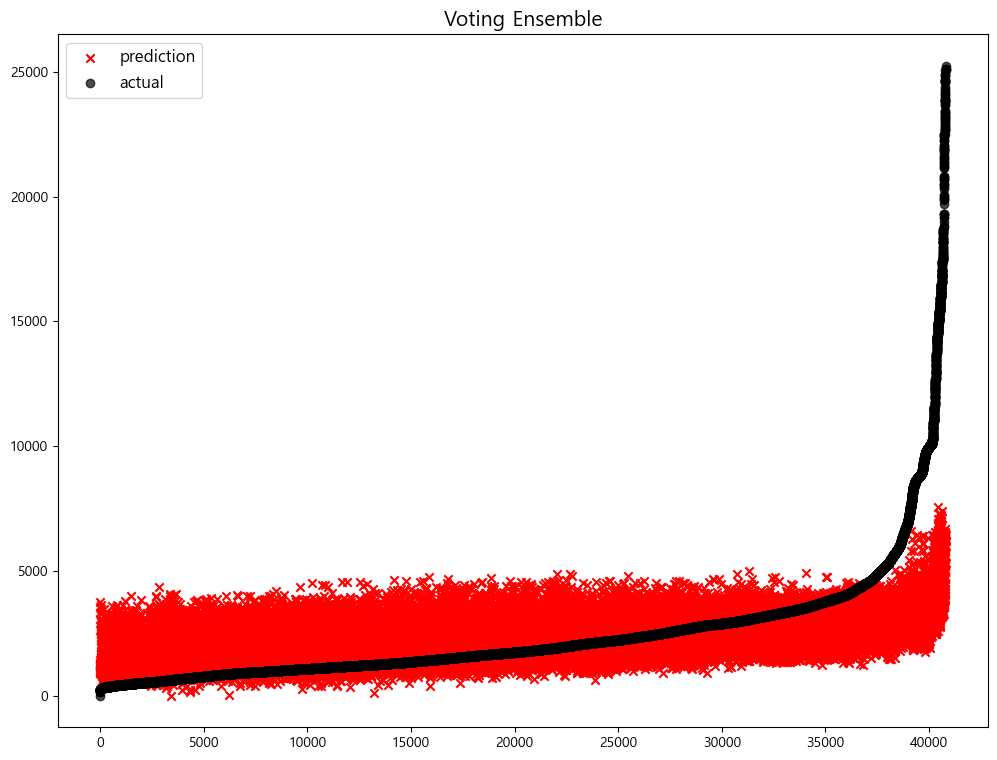

                       model           mse
0        Standard ElasticNet  5.343432e+06
1   ElasticNet(l1_ratio=0.2)  5.340955e+06
2   ElasticNet(l1_ratio=0.5)  5.332145e+06
3   ElasticNet(l1_ratio=0.8)  5.317048e+06
4     No Standard ElasticNet  5.317048e+06
5        Lasso(alpha=0.0001)  5.297810e+06
6         Lasso(alpha=0.001)  5.297809e+06
7          Lasso(alpha=0.01)  5.297807e+06
8           Lasso(alpha=0.1)  5.297785e+06
9           LinearRegression  5.297717e+06
10       Ridge(alpha=0.0001)  5.297717e+06
11        Ridge(alpha=0.001)  5.297717e+06
12         Ridge(alpha=0.01)  5.297717e+06
13          Ridge(alpha=0.1)  5.297717e+06
14            Ridge(alpha=1)  5.297717e+06
15           Ridge(alpha=10)  5.297716e+06
16          Ridge(alpha=100)  5.297711e+06
17            Lasso(alpha=1)  5.297629e+06
18           Voting Ensemble  4.556689e+06
19           Poly ElasticNet  3.085862e+06


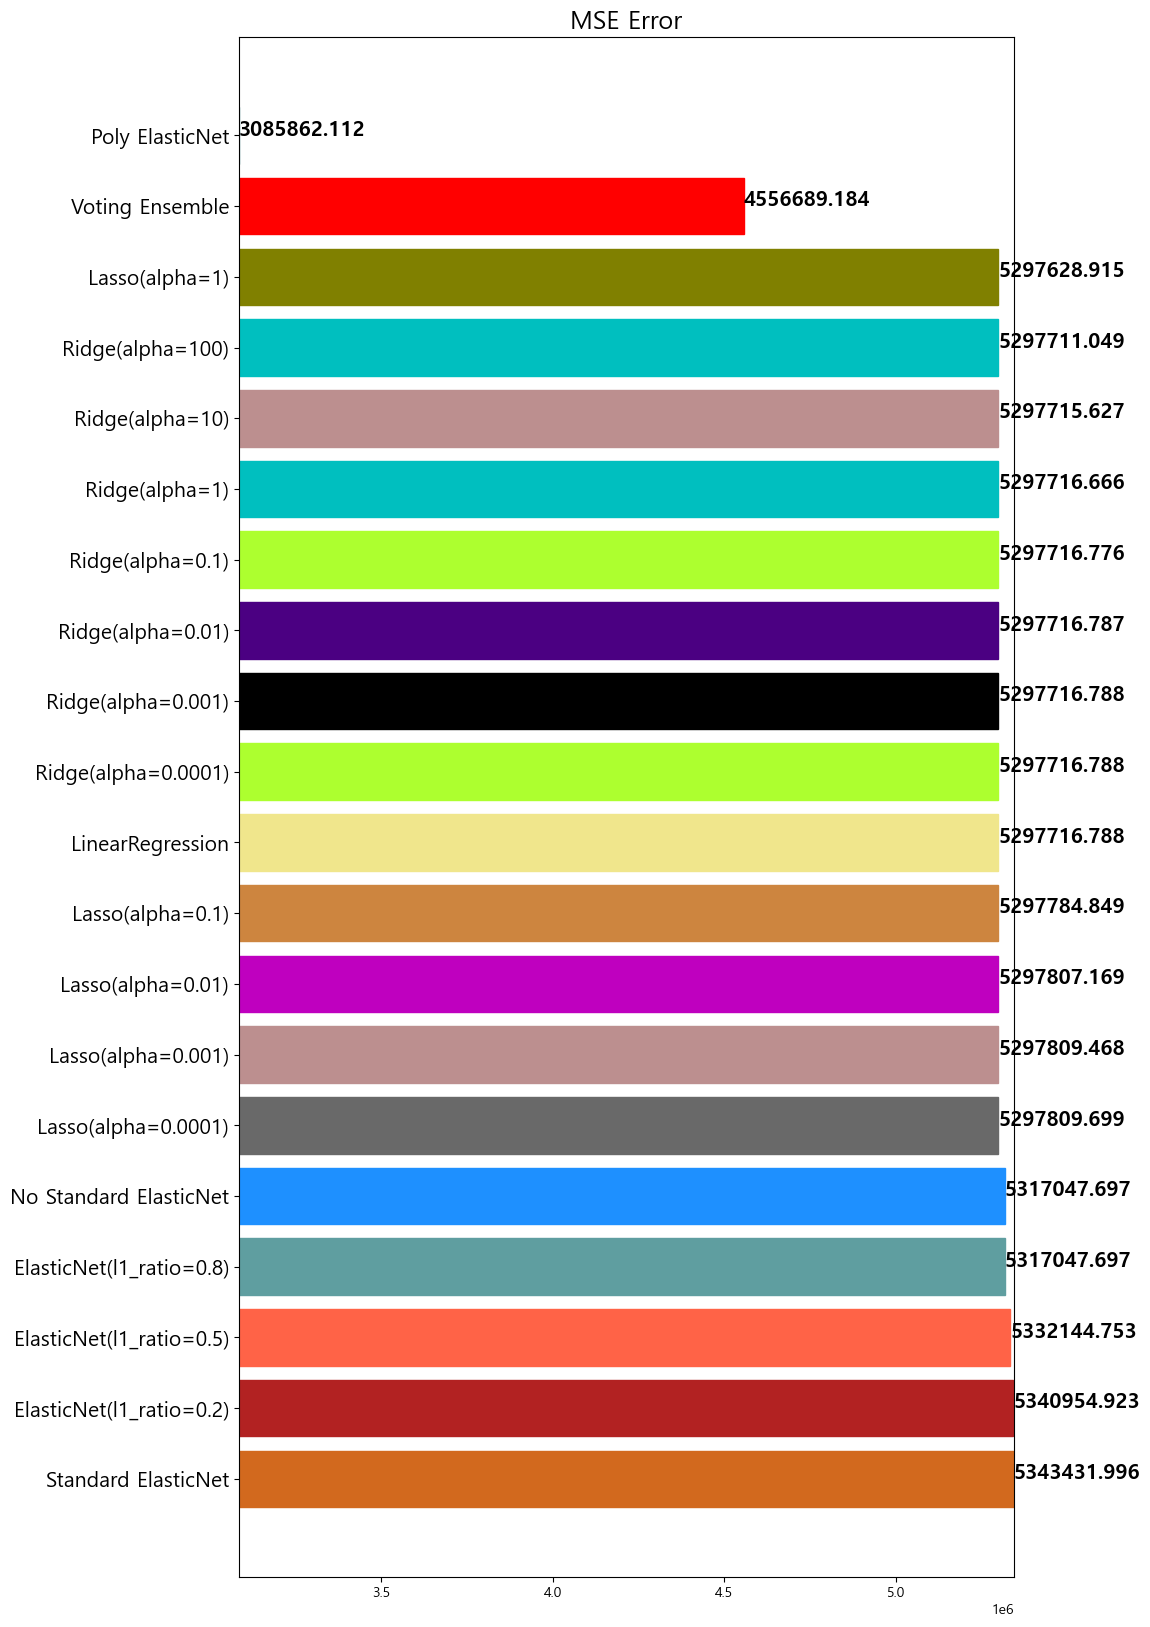

In [113]:
voting_regressor = VotingRegressor(single_models, n_jobs=-1)
voting_regressor.fit(x_train, y_train)
voting_pred = voting_regressor.predict(x_test)
mse_eval('Voting Ensemble', voting_pred, y_test)

#### Voting 앙상블 보다 poly_pipeline(3차) - ElasticNet 성능이 더 좋음

#### 배깅(Bagging)

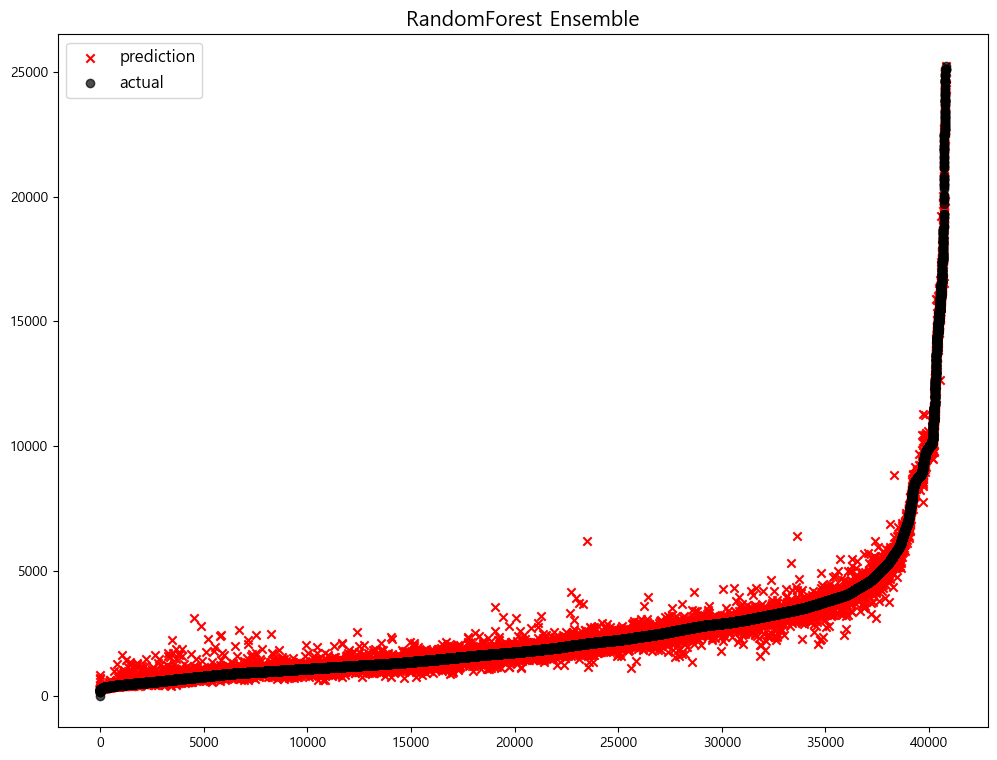

                       model           mse
0        Standard ElasticNet  5.343432e+06
1   ElasticNet(l1_ratio=0.2)  5.340955e+06
2   ElasticNet(l1_ratio=0.5)  5.332145e+06
3   ElasticNet(l1_ratio=0.8)  5.317048e+06
4     No Standard ElasticNet  5.317048e+06
5        Lasso(alpha=0.0001)  5.297810e+06
6         Lasso(alpha=0.001)  5.297809e+06
7          Lasso(alpha=0.01)  5.297807e+06
8           Lasso(alpha=0.1)  5.297785e+06
9           LinearRegression  5.297717e+06
10       Ridge(alpha=0.0001)  5.297717e+06
11        Ridge(alpha=0.001)  5.297717e+06
12         Ridge(alpha=0.01)  5.297717e+06
13          Ridge(alpha=0.1)  5.297717e+06
14            Ridge(alpha=1)  5.297717e+06
15           Ridge(alpha=10)  5.297716e+06
16          Ridge(alpha=100)  5.297711e+06
17            Lasso(alpha=1)  5.297629e+06
18           Voting Ensemble  4.556689e+06
19           Poly ElasticNet  3.085862e+06
20     RandomForest Ensemble  2.433523e+04


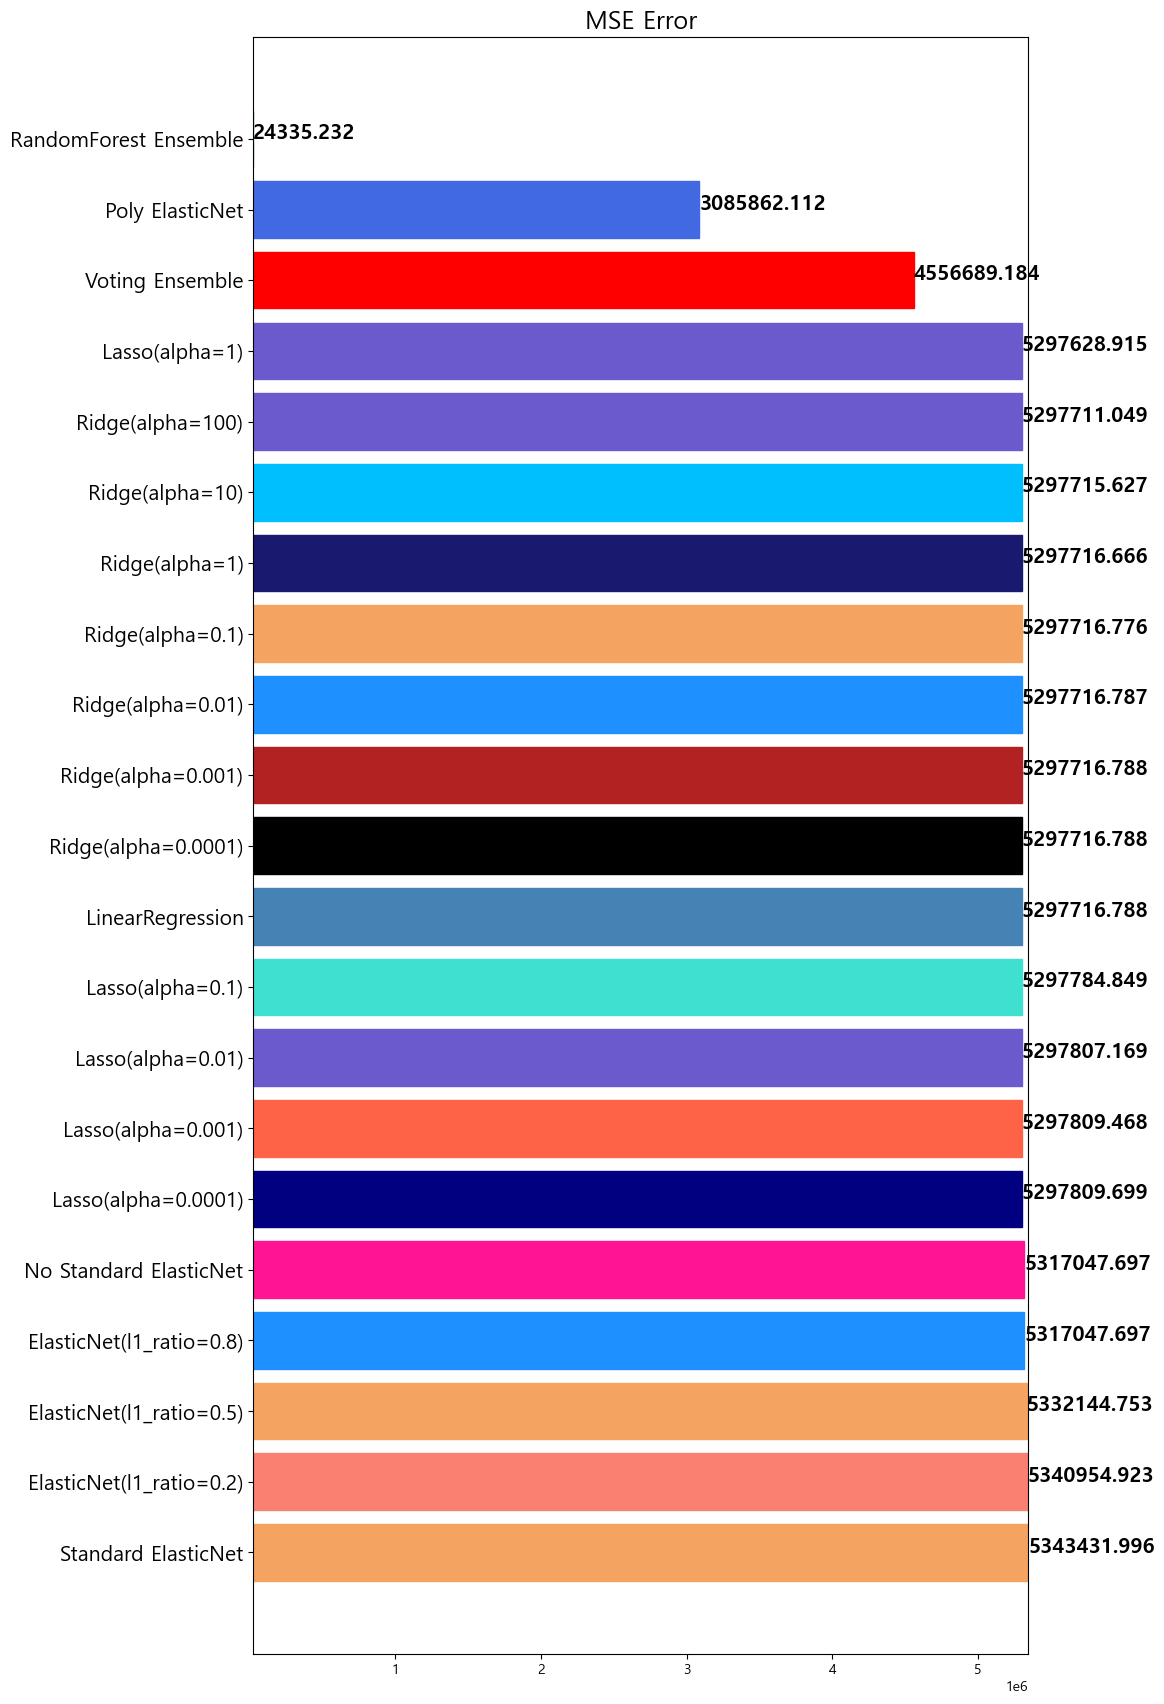

In [114]:
rfr_model = RandomForestRegressor(random_state = 42, n_jobs = -1)
rfr_model.fit(x_train, y_train)
rfr_pred = rfr_model.predict(x_test)
mse_eval('RandomForest Ensemble', rfr_pred, y_test)

##### 파라미터 최적화

In [115]:
model = RandomForestRegressor(random_state = 42, n_jobs = -1)
params = {'n_estimators' : [10, 50, 100, 200, 400, 500, 600, 700], 'max_depth' : [8, 9, 10, 11, 12, 13]}
grid = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [8, 9, 10, 11, 12, 13],
                         'n_estimators': [10, 50, 100, 200, 400, 500, 600,
                                          700]})

In [116]:
print('GridSearchCV 최적 파라미터:', grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

GridSearchCV 최적 파라미터: {'max_depth': 13, 'n_estimators': 700}
GridSearchCV 최고 정확도: 0.9858


##### 파라미터 적용

                                model           mse
0                 Standard ElasticNet  5.343432e+06
1            ElasticNet(l1_ratio=0.2)  5.340955e+06
2            ElasticNet(l1_ratio=0.5)  5.332145e+06
3            ElasticNet(l1_ratio=0.8)  5.317048e+06
4              No Standard ElasticNet  5.317048e+06
5                 Lasso(alpha=0.0001)  5.297810e+06
6                  Lasso(alpha=0.001)  5.297809e+06
7                   Lasso(alpha=0.01)  5.297807e+06
8                    Lasso(alpha=0.1)  5.297785e+06
9                    LinearRegression  5.297717e+06
10                Ridge(alpha=0.0001)  5.297717e+06
11                 Ridge(alpha=0.001)  5.297717e+06
12                  Ridge(alpha=0.01)  5.297717e+06
13                   Ridge(alpha=0.1)  5.297717e+06
14                     Ridge(alpha=1)  5.297717e+06
15                    Ridge(alpha=10)  5.297716e+06
16                   Ridge(alpha=100)  5.297711e+06
17                     Lasso(alpha=1)  5.297629e+06
18          

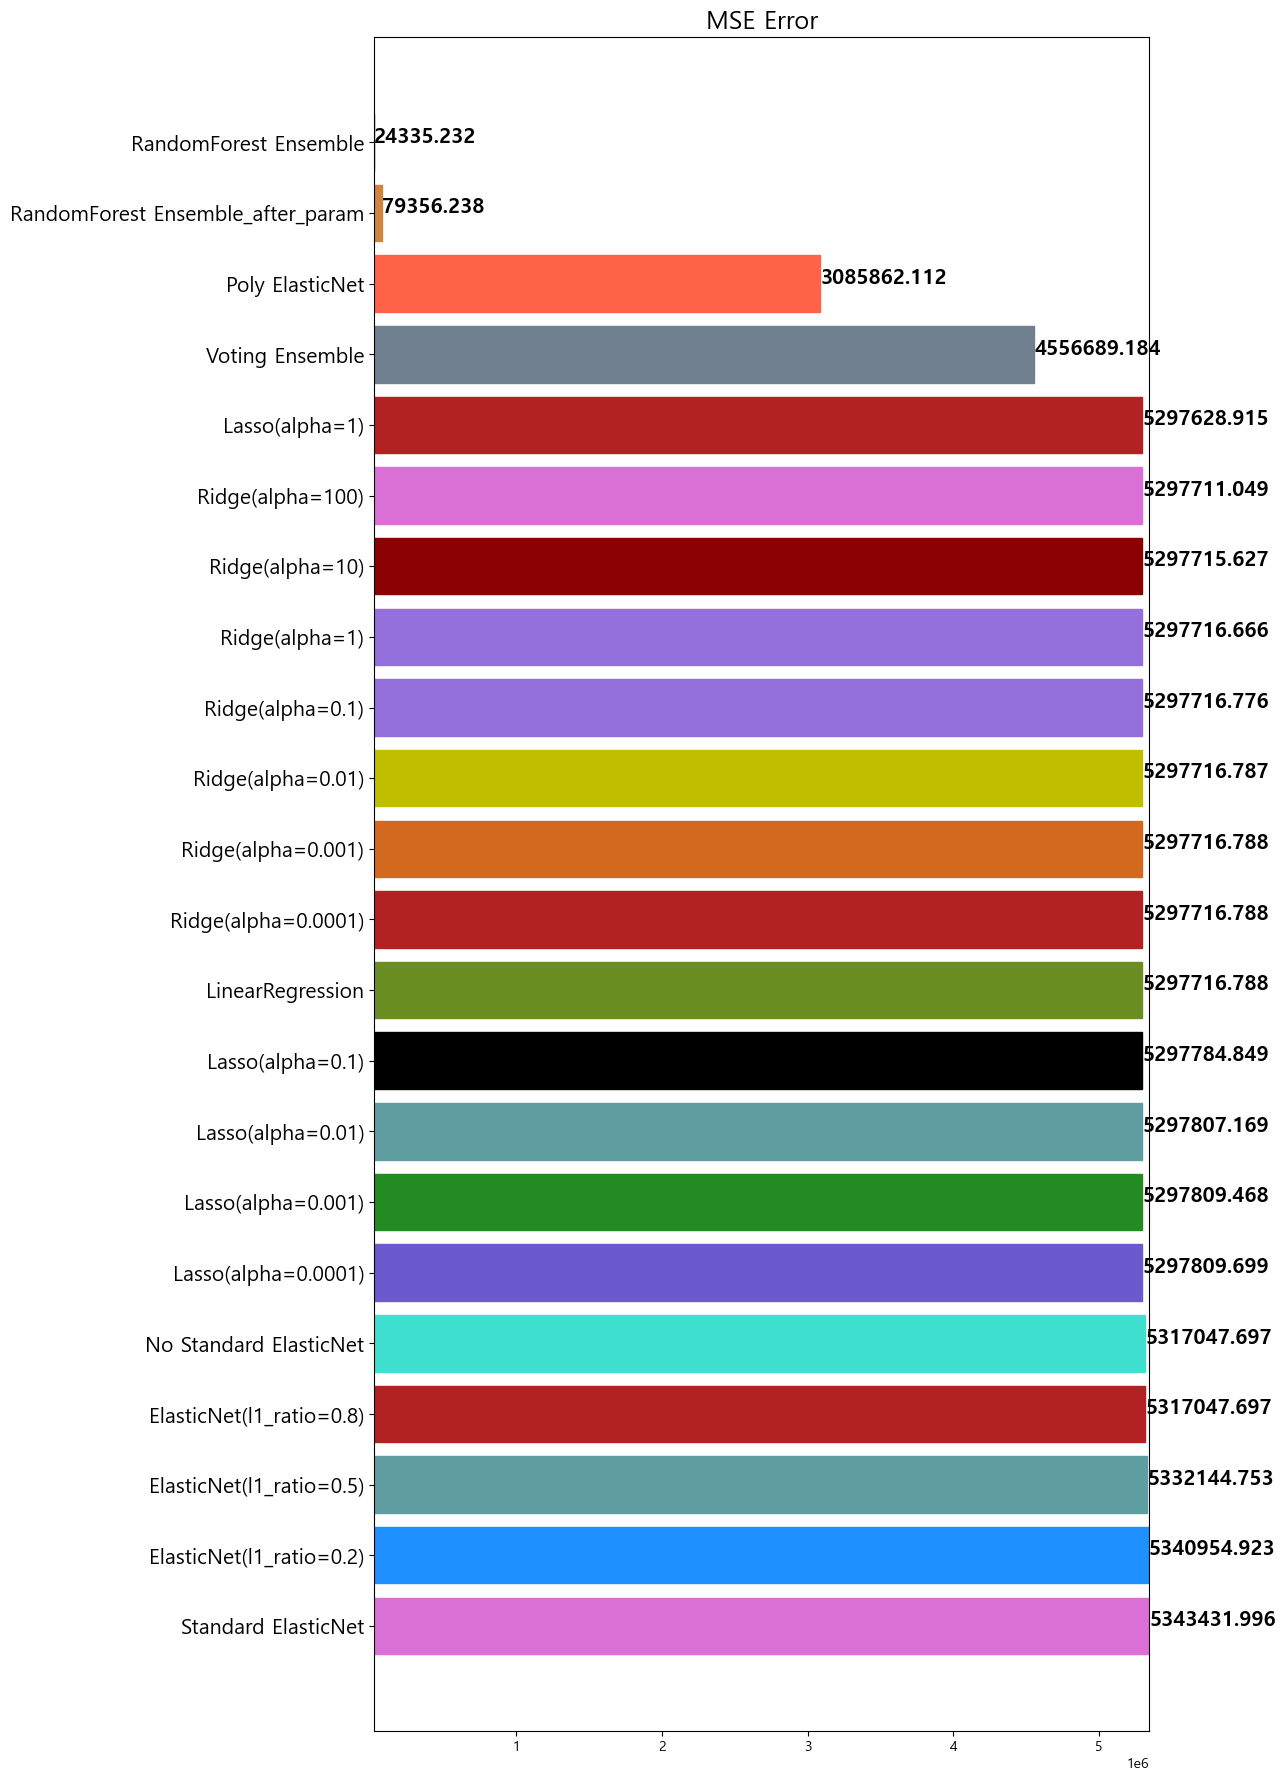

In [117]:
rfr_model = RandomForestRegressor(random_state = 42, n_estimators=700, max_depth =13, n_jobs = -1)
rfr_model.fit(x_train, y_train)
rfr_pred = rfr_model.predict(x_test)
mse_eval('RandomForest Ensemble_after_param', rfr_pred, y_test)

#### 부스팅 (Boosting) - GradientBoostingRegressor

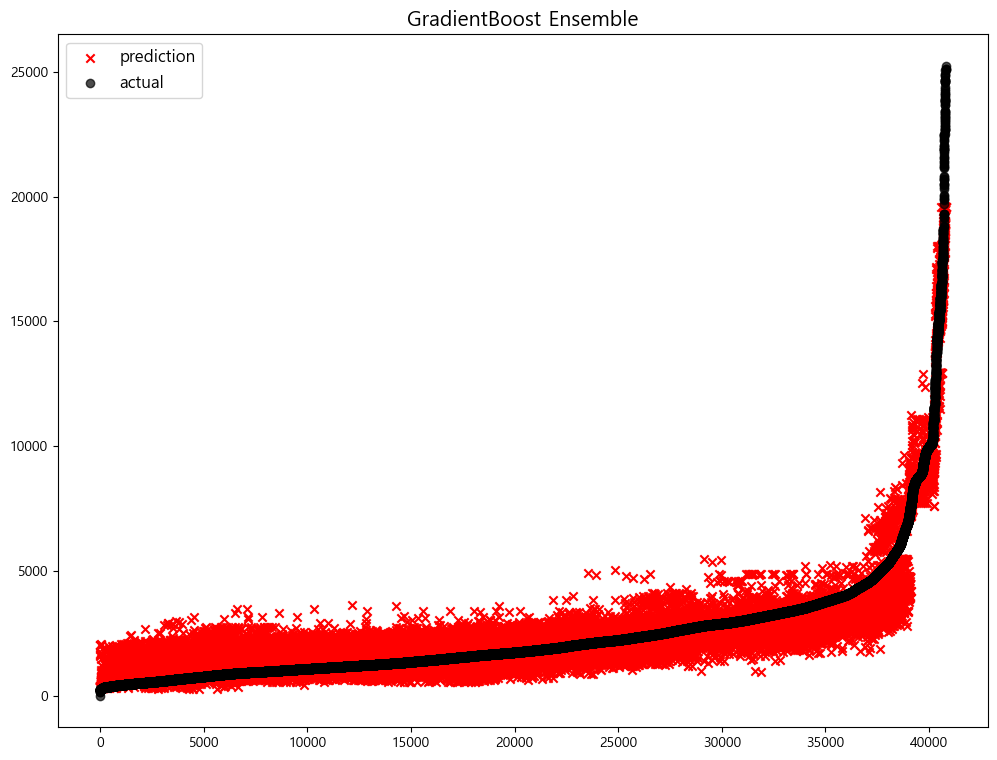

                                model           mse
0                 Standard ElasticNet  5.343432e+06
1            ElasticNet(l1_ratio=0.2)  5.340955e+06
2            ElasticNet(l1_ratio=0.5)  5.332145e+06
3            ElasticNet(l1_ratio=0.8)  5.317048e+06
4              No Standard ElasticNet  5.317048e+06
5                 Lasso(alpha=0.0001)  5.297810e+06
6                  Lasso(alpha=0.001)  5.297809e+06
7                   Lasso(alpha=0.01)  5.297807e+06
8                    Lasso(alpha=0.1)  5.297785e+06
9                    LinearRegression  5.297717e+06
10                Ridge(alpha=0.0001)  5.297717e+06
11                 Ridge(alpha=0.001)  5.297717e+06
12                  Ridge(alpha=0.01)  5.297717e+06
13                   Ridge(alpha=0.1)  5.297717e+06
14                     Ridge(alpha=1)  5.297717e+06
15                    Ridge(alpha=10)  5.297716e+06
16                   Ridge(alpha=100)  5.297711e+06
17                     Lasso(alpha=1)  5.297629e+06
18          

In [119]:
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(x_train, y_train)
gbr_pred = gbr_model.predict(x_test)
mse_eval('GradientBoost Ensemble', gbr_pred, y_test)

##### 파라미터 최적화

In [120]:
model = GradientBoostingRegressor(random_state = 42)
params = {
    'n_estimators':[10, 20, 50, 100, 200, 500, 1000, 2000],
    'learning_rate' : [ 0.05, 0.1, 0.01],
    'subsample' : [0.1, 0,2, 0,5, 0.8, 0.9, 1]
}
grid = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.01],
                         'n_estimators': [10, 20, 50, 100, 200, 500, 1000,
                                          2000],
                         'subsample': [0.1, 0, 2, 0, 5, 0.8, 0.9, 1]})

In [122]:
print('GridSearchCV 최적 파라미터:', grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

GridSearchCV 최적 파라미터: {'learning_rate': 0.1, 'n_estimators': 2000, 'subsample': 0.9}
GridSearchCV 최고 정확도: 0.9798


##### 파라미터 적용

In [123]:
gbr_model = GradientBoostingRegressor(random_state=42, n_estimators=2000, learning_rate= 0.1, subsample=0.9)
gbr_model.fit(x_train, y_train)
gbr_pred = gbr_model.predict(x_test)
mse_eval('GradientBoost Ensemble_after_param', gbr_pred, y_test)

KeyboardInterrupt: 

#### XGBoost 

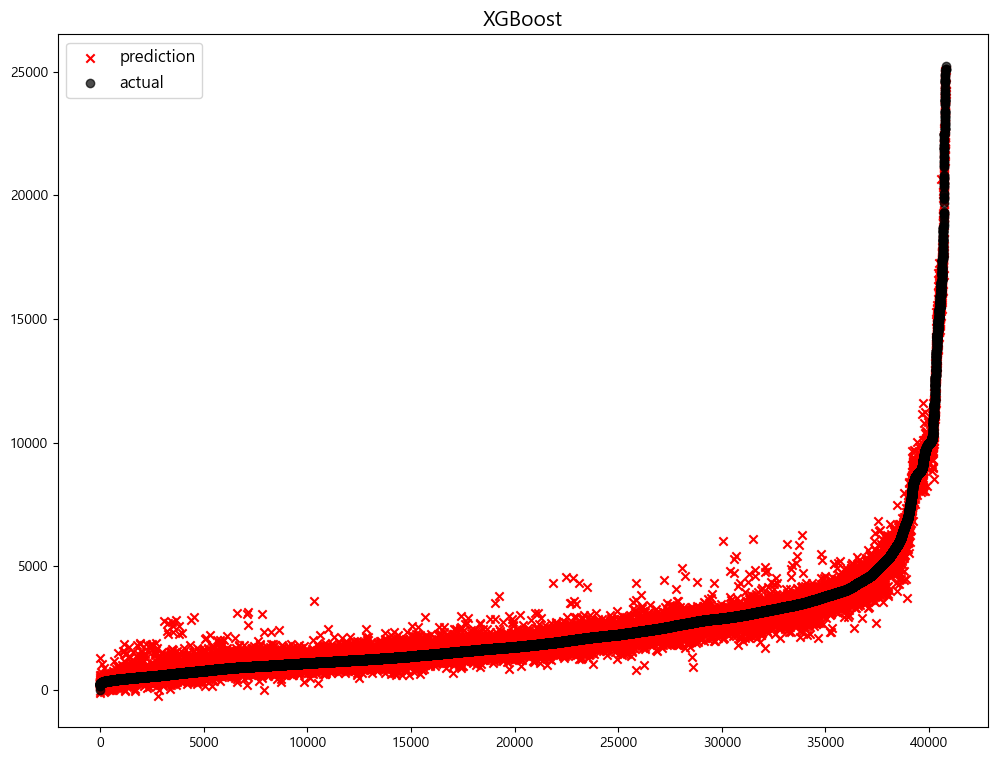

                                 model           mse
0                  Standard ElasticNet  5.343432e+06
1             ElasticNet(l1_ratio=0.2)  5.340955e+06
2             ElasticNet(l1_ratio=0.5)  5.332145e+06
3             ElasticNet(l1_ratio=0.8)  5.317048e+06
4               No Standard ElasticNet  5.317048e+06
5                  Lasso(alpha=0.0001)  5.297810e+06
6                   Lasso(alpha=0.001)  5.297809e+06
7                    Lasso(alpha=0.01)  5.297807e+06
8                     Lasso(alpha=0.1)  5.297785e+06
9                     LinearRegression  5.297717e+06
10                 Ridge(alpha=0.0001)  5.297717e+06
11                  Ridge(alpha=0.001)  5.297717e+06
12                   Ridge(alpha=0.01)  5.297717e+06
13                    Ridge(alpha=0.1)  5.297717e+06
14                      Ridge(alpha=1)  5.297717e+06
15                     Ridge(alpha=10)  5.297716e+06
16                    Ridge(alpha=100)  5.297711e+06
17                      Lasso(alpha=1)  5.2976

In [124]:
xgb_model = XGBRegressor(random_state=42, n_jobs = -1)
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)
mse_eval('XGBoost', xgb_pred, y_test)

##### 파라미터 최적화

In [126]:
model = XGBRegressor(random_state = 42, n_jobs = -1)
params = {
    'n_estimators':[10, 20, 50, 100, 200, 500, 1000, 2000],
    'learning_rate' : [ 0.05, 0.1, 0.01],
    'subsample' : [0.1, 0,2, 0,5, 0.8, 0,9, 1],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15]
}
grid = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid.fit(x_train, y_train)

KeyboardInterrupt: 

##### 파라미터 적용

In [ ]:
xgb_model = XGBRegressor(random_state=42, n_estimators= 10, learning_rate= 0.1, subsample= 0.8, max_depth= 7,  n_jobs = -1)
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)
mse_eval('XGBoost_after_param', xgb_pred, y_test)

#### LGBMRegressor

In [ ]:
lgbm_model = LGBMRegressor(random_state=42, n_jobs=-1)
lgbm_model.fit(x_train, y_train)
lgbm_pred = lgbm_model.predict(x_test)
mse_eval('LGBM', lgbm_pred, y_test)

In [ ]:
model = LGBMRegressor(random_state = 42, n_jobs = -1)
params = {
    'n_estimators':[10, 20, 50, 100, 200, 500, 1000, 2000],
    'learning_rate' : [ 0.05, 0.1, 0.01],
    'subsample' : [0.1, 0,2, 0,5, 0.8, 0.9, 1],
    'colsample_bytree' : [0.1, 0.2, 0.5, 0,8, 1],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15]
}
grid = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid.fit(x_train, y_train)

In [ ]:
lgbm_model = LGBMRegressor(random_state=42, n_jobs=-1)
lgbm_model.fit(x_train, y_train)
lgbm_pred = lgbm_model.predict(x_test)
mse_eval('LGBM', lgbm_pred, y_test)

#### StackingRegressor

In [ ]:
stack_models = [
    ('elasticnet', poly_pipeline), 
    ('randomforest', rfr_model), 
    ('gbr', gbr_model),
    ('lgbm', lgbm_model),
]

In [ ]:
stack_reg = StackingRegressor(stack_models, final_estimator=xgb, n_jobs=-1)
stack_reg.fit(x_train, y_train)
stack_pred = stack_reg.predict(x_test)
mse_eval('Stacking Ensemble', stack_pred, y_test)

## Regression Model Fit

In [ ]:
model = RandomForestRegressor()
model.fit(train_x, train_y)

## Test Data Pre-Processing

In [ ]:
test_df['month'] = test_df['일시'].apply(lambda x : int(x[4:6]))
test_df['day'] = test_df['일시'].apply(lambda x : int(x[6:8]))
test_df['time'] = test_df['일시'].apply(lambda x : int(x[9:11]))

In [ ]:
test_x = test_df.drop(columns=['num_date_time', '일시'])

## Inference

In [ ]:
preds = model.predict(test_x)